In [1]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (Sử dụng Dual ControlNet)

import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline, ControlNetModel, StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
#from controlnet_aux import OpenposeDetector, DepthEstimator, CannyDetector
# Thêm Preprocessors
# Thay thế dòng cũ:
# from controlnet_aux import OpenposeDetector, DepthEstimator, CannyDetector

# Bằng các dòng mới nà
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH...

# Hãy xóa hoặc chú thích dòng import cũ này:
# from controlnet_aux import OpenposeDetector, DepthEstimator, CannyDetector

# VÀ THAY THẾ BẰNG 3 DÒNG SAU:

# Import OpenPose Detector
from controlnet_aux.open_pose import OpenposeDetector
# Import Depth Estimator (Nếu vẫn lỗi, hãy thử 'midas' thay vì 'depth')
from controlnet_aux.midas import DepthEstimator # Changed import path
# Import Canny Detector
from controlnet_aux.canny import CannyDetector
# ... (Các dòng import khác giữ nguyên)

# Sau đó, hãy chạy lại Cell 1.


import numpy as np # Cần cho hiển thị và xử lý mảng
import warnings
warnings.filterwarnings("ignore")

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện (Bao gồm xformers để tối ưu VRAM)
!pip install diffusers transformers accelerate controlnet_aux opencv-python-headless xformers
print("\nĐã cài đặt Diffusers, ControlNet Aux, và xformers.")

# 2. Thiết lập thư mục đầu ra
OUTPUT_DIR = "Pro_Auto_Pose_Output"
CONSISTENCY_DIR = "Pro_Consistency_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CONSISTENCY_DIR, exist_ok=True)
os.environ['OUTPUT_DIR'] = OUTPUT_DIR
os.environ['CONSISTENCY_DIR'] = CONSISTENCY_DIR

# 3. Kiểm tra GPU và thiết lập Device
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache() # Dọn dẹp VRAM
print(f"Thiết bị đang sử dụng: {device}")

# 4. Tải BASE Stable Diffusion Pipeline (Dùng T2I để tạo ảnh tham chiếu)
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
        print("Đã kích hoạt tối ưu hóa xformers.")
    except Exception:
        print("CẢNH BÁO: Không thể kích hoạt xformers. Vui lòng kiểm tra cài đặt.")


# 5. Tải Preprocessor (Dùng để trích xuất Control Map)
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)
depth_detector = DepthEstimator.from_pretrained("Intel/dpt-large").to(device)
canny_detector = CannyDetector() # Canny thường không cần chuyển sang device
print("Đã tải tất cả Preprocessor (OpenPose, Depth, Canny).")

print("\n--- HOÀN TẤT CELL 1: SẴN SÀNG TẠO ẢNH ---")

KeyboardInterrupt: 

In [ ]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (Sử dụng Dual ControlNet)
# ... (các dòng import khác)

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện (Bao gồm xformers và chỉ định phiên bản cũ hơn của controlnet_aux)
!pip install diffusers transformers accelerate xformers
!pip install controlnet_aux  # Cài đặt phiên bản ổn định đã được kiểm chứng
# ...

--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---


In [ ]:
# @title 3. TẠO ẢNH NỀN CỐ ĐỊNH BẰNG AI VÀ TRÍCH XUẤT DEPTH MAP

# Cần đảm bảo Cell 1 đã chạy và có biến 'pipe' (StableDiffusionPipeline) và 'depth_detector'
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

# --- 1. PROMPT TẠO ẢNH NỀN LÝ TƯỞNG ---
# Prompt phải mô tả một bối cảnh cố định, không có nhân vật
BACKGROUND_PROMPT = "minimalist modern office background, clean desk, one dark executive chair slightly pushed back, large window with soft sunlight, smooth polished floor, high quality, cinematic lighting, centered"
NEG_BG_PROMPT = "person, people, blurry, low resolution, worst quality, out of focus, cartoon, illustration"
BG_SEED = 12345 # Dùng seed cố định để đảm bảo bối cảnh luôn giống nhau

BG_DEPTH_MAP = None

print("--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---")

try:
    # 2. TẠO ẢNH NỀN BẰNG T2I
    generator_bg = torch.Generator(device).manual_seed(BG_SEED)

    # Sử dụng pipeline T2I đã tải ở Cell 1
    BG_IMAGE = pipe(
        prompt=BACKGROUND_PROMPT,
        negative_prompt=NEG_BG_PROMPT,
        num_inference_steps=50,
        guidance_scale=8.0,
        generator=generator_bg,
        height=768,
        width=768
    ).images[0]

    BG_IMAGE_PATH = os.path.join(os.environ['OUTPUT_DIR'], "AI_Generated_Background.png")
    BG_IMAGE.save(BG_IMAGE_PATH)
    print(f"-> Đã tạo và lưu ảnh nền cố định bằng AI tại: {BG_IMAGE_PATH}")

    # 3. TRÍCH XUẤT DEPTH MAP TỪ ẢNH NỀN ĐÃ TẠO
    # Sử dụng depth_detector đã tải ở Cell 1
    globals()['BG_DEPTH_MAP'] = depth_detector(BG_IMAGE)
    print("-> Đã trích xuất Depth Map cho bối cảnh thành công.")

    # 4. HIỂN THỊ KIỂM TRA
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(BG_IMAGE); axes[0].set_title("1. Ảnh Nền AI Gốc", fontsize=10); axes[0].axis('off')
    axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray'); axes[1].set_title("2. Depth Map (Control Map cho Bối cảnh)", fontsize=10); axes[1].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"!!! LỖI TẠO HOẶC XỬ LÝ ẢNH NỀN AI: {e}")
    print("Sử dụng Depth Map trung tính để tránh lỗi runtime.")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white') # Fallback an toàn

print("\n--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ AI ---")


In [ ]:
# @title 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET (POSE + DEPTH)

# --- CẤU HÌNH VÀ TẢI PIPELINE PHỨC HỢP ---
try:
    # 1. Tải ControlNet Model (Pose)
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)

    # 2. Tải ControlNet Model (Depth)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # 3. Tạo Pipeline với LIST ControlNet
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet] # LIST ControlNet Models
    ).to(device)
    if device == "cuda":
        i2i_pipe.enable_xformers_memory_efficient_attention()
    print("Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")

except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None


# --- DANH SÁCH CÁC CẶP FILE VÀ PROMPT CỦA CHÚNG (Lấy từ Cell 2) ---
# TẠO 4 ẢNH ĐỂ TEST CÁC TƯ THẾ KHÁC NHAU
PROMPT_MAP_FULL = [
    # Cần đảm bảo các file OpenPose này tồn tại!
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, torso leaning forward aggressively, challenging body language"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, shoulders slightly hunched, head tilted, defensive posture"),
    ("NU_3_Action_Uniform_V2_openpose.png", "NU", "arms tightly crossed over chest, legs crossed, torso turned slightly away, rejecting body language"),
    ("NAM_4_Action_Uniform_V2_openpose.png", "NAM", "both palms turned outward in a gesture of honesty, feet shoulder-width apart, pleading body posture"),
]

# Style Prompt Đồng Nhất
CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, minimal office setting, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, minimal office setting, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects" # Furniture bị loại bỏ bởi ControlNet Depth

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(OUTPUT_DIR, pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        generator = torch.Generator(device).manual_seed(100 + i)

        # --- GỌI DUAL CONTROLNET ---
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=ref_image,
            control_image=[pose_image, globals()['BG_DEPTH_MAP']], # LIST Control Maps
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,
            controlnet_conditioning_scale=[1.0, 1.5], # Pose: Mạnh (1.0), Depth: Vừa phải (0.8)
            strength=0.7, # Buộc thay đổi tư thế, giữ nhân vật
            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ HIỂN THỊ ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(CONSISTENCY_DIR, output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")
r
    print("\n--- HOÀN TẤT VIỆC TẠO ẢNH SẢN XUẤT ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")



Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).

BẮT ĐẦU TẠO 4 ẢNH VỚI DUAL CONTROLNET...


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_1_NU_FINAL_IMAGE.png


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_2_NAM_FINAL_IMAGE.png

--- HOÀN TẤT VIỆC TẠO ẢNH SẢN XUẤT ---


In [8]:
# @title 0. Tiện Ích Đồ Họa
import matplotlib.pyplot as plt

def plot_image_in_subplot(image, title, position, rows=1, cols=2):
    """Vẽ một ảnh vào subplot."""
    plt.subplot(rows, cols, position)
    plt.imshow(image)
    plt.title(title, fontsize=10)
    plt.axis('off')

def show_images(base_image, pose_image, file_prefix, figsize=(7.0, 3.5)):
    """Hiển thị Ảnh Gốc và OpenPose Map cạnh nhau với kích thước nhỏ (~160px)."""
    print(f"--- HIỂN THỊ KẾT QUẢ NẰM NGANG {file_prefix} ---")

    plt.figure(figsize=figsize)

    # 1. Vẽ Ảnh Gốc
    plot_image_in_subplot(base_image, f"1. Ảnh Gốc ({file_prefix})", 1)

    # 2. Vẽ OpenPose Map
    plot_image_in_subplot(pose_image, f"2. OpenPose Map ({file_prefix})", 2)

    plt.tight_layout()
    plt.show()
    print("-" * 30)

# Lưu ý: Các hàm này phải được chạy trước khi gọi ở Cell 2.

In [4]:
# @title 1️⃣ CÀI ĐẶT THƯ VIỆN & DEPENDENCY (TỐI ƯU CHO CUDA 12.6)
# ======================================================================
import sys, platform
print("=" * 70)
print("🚀 BẮT ĐẦU CÀI ĐẶT THƯ VIỆN (Tối ưu cho môi trường Python / CUDA)")
print("=" * 70)
print(f"🔹 Python: {sys.version.split()[0]}")
print(f"🔹 Hệ điều hành: {platform.system()} {platform.release()}")

# ----------------------------------------------------------------------
# 1️⃣ CÀI ĐẶT PYTORCH (CUDA 12.6)
# Torch 2.8.0+cu126 tương thích tốt nhất với CUDA 12.6
print("\n--- 1. Cài đặt PyTorch (CUDA 12.6) ---")
!pip install --upgrade --force-reinstall torch==2.8.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# ----------------------------------------------------------------------
# 2️⃣ CÀI ĐẶT THƯ VIỆN AI (Diffusers / Transformers / Accelerate)
print("\n--- 2. Cài đặt thư viện AI (Hugging Face Ecosystem) ---")
!pip install diffusers==0.35.2 transformers==4.57.1 accelerate==1.10.1 --upgrade

# ----------------------------------------------------------------------
# 3️⃣ CÀI ĐẶT THƯ VIỆN HỖ TRỢ (ControlNet, OpenCV, Pillow)
print("\n--- 3. Cài đặt thư viện hỗ trợ (ControlNet / OpenCV / Pillow) ---")
!pip install controlnet_aux==0.0.10 opencv-python==4.12.0 Pillow --upgrade

# ----------------------------------------------------------------------
# 4️⃣ CÀI ĐẶT XFORMERS (Tối ưu tốc độ & bộ nhớ GPU)
print("\n--- 4. Cài đặt XFormers (Tối ưu GPU Memory) ---")
!pip install xformers==0.0.32.post2 --upgrade

print("\n✅ Hoàn tất cài đặt tất cả thư viện. Kiểm tra phiên bản bên dưới ⬇️")


# @title Sửa lỗi Xung đột Nâng Cao: Cố định NumPy
print("--- 1. Gỡ bỏ NumPy hiện tại và Cố định NumPy 2.2.0 ---")
!pip uninstall -y numpy

# Cố định phiên bản NumPy 2.2.0 để thỏa mãn các ràng buộc của OpenCV/TensorFlow/CuPy
!pip install numpy==2.2.0

# Nâng cấp Numba để đảm bảo nó tương thích với NumPy 2.x
# Numba 0.60+ đã hỗ trợ NumPy 2.x
print("\n--- 2. Cài đặt lại Numba Tương thích ---")
!pip install numba --upgrade

# Cài đặt lại rembg và dependency onnxruntime
print("\n--- 3. Cài đặt lại rembg/onnxruntime ---")
!pip install rembg --quiet
!pip install onnxruntime --quiet

print("\n✅ HOÀN TẤT. Vui lòng chạy lại các cell khởi tạo (Cell 1, 2) theo thứ tự.")


🚀 BẮT ĐẦU CÀI ĐẶT THƯ VIỆN (Tối ưu cho môi trường Python / CUDA)
🔹 Python: 3.12.12
🔹 Hệ điều hành: Linux 6.6.105+

--- 1. Cài đặt PyTorch (CUDA 12.6) ---
Looking in indexes: https://download.pytorch.org/whl/cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 849.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━


--- 2. Cài đặt thư viện AI (Hugging Face Ecosystem) ---

--- 3. Cài đặt thư viện hỗ trợ (ControlNet / OpenCV / Pillow) ---
ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.12.0 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86, 4.12.0.88)
ERROR: No matching distribution found for opencv-python==4.12.0

--- 4. Cài đặt XFormers (Tối ưu GPU Memory) ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 9.0 MB/s eta 0:00:00

✅ Hoàn tất cài đặt tất cả thư viện. Kiểm tra phiên bản bên dưới ⬇️
--- 1. Gỡ bỏ NumPy hiện tại và Cố định NumPy 2.2.0 ---
Found existing installation: numpy 2.3.3
Uninsta


--- 2. Cài đặt lại Numba Tương thích ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cuda 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
distributed-ucxx-cu12 0.44.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
cudf-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
c

In [5]:
# @title 1b. HIỂN THỊ PHIÊN BẢN TOÀN BỘ CÁC THƯ VIỆN (MỞ RỘNG)
import sys, platform, subprocess, importlib, traceback
import importlib.metadata as importlib_metadata
import torch

print("=" * 90)
print("🧩 THÔNG TIN MÔI TRƯỜNG VÀ PHIÊN BẢN THƯ VIỆN (CHI TIẾT)")
print("=" * 90)

# System / Python / Torch
print(f"🔹 Python: {sys.version.split()[0]} ({sys.executable})")
print(f"🔹 OS: {platform.system()} {platform.release()}")
print("\n🔥 PYTORCH / CUDA")
print("-" * 90)
print(f"🔸 PyTorch: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔸 Device: {device}")
if torch.cuda.is_available():
    try:
        print(f"🔸 CUDA: {torch.version.cuda}")
        print(f"🔸 GPU: {torch.cuda.get_device_name(0)}")
    except Exception as e:
        print("🔸 GPU info error:", e)

# Helper: safe version fetch
def get_version(import_name, pkg_name=None):
    pkg_name = pkg_name or import_name
    try:
        mod = importlib.import_module(import_name)
        ver = getattr(mod, "__version__", None)
        if ver:
            return f"{ver} (import ok)"
    except Exception as e:
        # import failed, try metadata
        try:
            ver = importlib_metadata.version(pkg_name)
            return f"{ver} (import FAILED but metadata exists)"
        except Exception:
            return f"(not installed / import failed: {e})"
    # fallback to metadata
    try:
        ver = importlib_metadata.version(pkg_name)
        return f"{ver} (import ok, version from metadata)"
    except Exception as e:
        return f"(unknown, metadata failed: {e})"

# List of packages to check (display name, import name, package name for metadata)
packages = [
    ("torch", "torch", "torch"),
    ("torchvision", "torchvision", "torchvision"),
    ("torchaudio", "torchaudio", "torchaudio"),
    ("diffusers", "diffusers", "diffusers"),
    ("transformers", "transformers", "transformers"),
    ("accelerate", "accelerate", "accelerate"),
    ("huggingface_hub", "huggingface_hub", "huggingface_hub"),
    ("tokenizers", "tokenizers", "tokenizers"),
    ("safetensors", "safetensors", "safetensors"),
    ("controlnet_aux", "controlnet_aux", "controlnet_aux"),
    ("controlnet_aux.midas", "controlnet_aux.midas", "controlnet_aux"),
    ("controlnet_aux.open_pose", "controlnet_aux.open_pose", "controlnet_aux"),
    ("opencv-python (cv2)", "cv2", "opencv-python"),
    ("xformers", "xformers", "xformers"),
    ("rembg", "rembg", "rembg"),
    ("onnxruntime", "onnxruntime", "onnxruntime"),
    ("numba", "numba", "numba"),
    ("numpy", "numpy", "numpy"),
    ("fsspec", "fsspec", "fsspec"),
    ("datasets", "datasets", "datasets"),
    ("Pillow (PIL)", "PIL", "Pillow"),
    ("matplotlib", "matplotlib", "matplotlib"),
    ("scipy", "scipy", "scipy"),
    ("skimage", "skimage", "scikit-image"),
    ("torchvision.models", "torchvision.models", "torchvision"),
    ("cv2 (version)", "cv2", "opencv-python"),
]

print("\n🔎 Kiểm tra các package quan trọng")
print("-" * 90)
for display, imp, pkg in packages:
    ver = get_version(imp, pkg)
    print(f"{display:28s}: {ver}")

# Show a compact pip list (top 120 lines) to inspect installed wheels
print("\n📦 `pip list` (top 120 lines):")
print("-" * 90)
try:
    out = subprocess.check_output([sys.executable, "-m", "pip", "list", "--format=columns"]).decode("utf-8").splitlines()
    for line in out[:120]:
        print(line)
except Exception as e:
    print("Không thể chạy pip list:", e)

# Run pip check to show dependency conflicts
print("\n⚠️ `pip check` (dependency conflicts):")
print("-" * 90)
try:
    check = subprocess.check_output([sys.executable, "-m", "pip", "check"], stderr=subprocess.STDOUT).decode("utf-8").strip()
    print(check if check else "No conflicts reported by pip check.")
except subprocess.CalledProcessError as e:
    print("pip check returned non-zero exit code. Output:")
    print(e.output.decode())
except Exception as e:
    print("Không thể chạy pip check:", e)

# Extra: show specific problematic versions that commonly conflict
print("\nℹ️ Kiểm tra nhanh một số cặp thường xung đột:")
try:
    import numpy as np
    import importlib
    print(f" - numpy: {np.__version__}")
except Exception as e:
    print(" - numpy: import failed", e)

for mod in ["numba", "onnxruntime", "rembg", "cv2", "xformers", "controlnet_aux"]:
    try:
        m = importlib.import_module(mod)
        print(f" - {mod}: import OK")
    except Exception as e:
        print(f" - {mod}: import FAILED -> {e}")

print("\n✅ Kiểm tra hoàn tất. Nếu có package import FAILED hoặc pip check báo xung đột, dán toàn bộ output ở đây — mình sẽ hướng dẫn chính xác các lệnh `pip install`/`pip uninstall` cần thiết.")
print("=" * 90)


🧩 THÔNG TIN MÔI TRƯỜNG VÀ PHIÊN BẢN THƯ VIỆN (CHI TIẾT)
🔹 Python: 3.12.12 (/usr/bin/python3)
🔹 OS: Linux 6.6.105+

🔥 PYTORCH / CUDA
------------------------------------------------------------------------------------------
🔸 PyTorch: 2.8.0+cu126
🔸 Device: cuda
🔸 CUDA: 12.6
🔸 GPU: Tesla T4

🔎 Kiểm tra các package quan trọng
------------------------------------------------------------------------------------------
torch                       : 2.8.0+cu126 (import ok)
torchvision                 : 0.23.0+cu126 (import ok)
torchaudio                  : 2.8.0+cu126 (import ok)
diffusers                   : 0.35.2 (import FAILED but metadata exists)
transformers                : 4.57.1 (import ok)
accelerate                  : 1.10.1 (import ok)
huggingface_hub             : 0.35.3 (import ok)
tokenizers                  : 0.22.1 (import ok)
safetensors                 : 0.6.2 (import ok)
controlnet_aux              : (not installed / import failed: No module named 'controlnet_aux')
controln

In [3]:
# @title 0. Sửa lỗi Xung đột Nâng Cao: Cố định NumPy và Numba

print("--- 1. Cố định NumPy và Numba để rembg hoạt động ổn định ---")
# Hạ cấp NumPy về phiên bản 1.x ổn định cuối cùng để thỏa mãn rembg
!pip uninstall -y numpy
!pip install numpy==1.26.4

# Cài đặt Numba 0.62.1 (đã được cài đặt thành công, giờ chỉ cần đảm bảo)
!pip install numba==0.62.1

print("\n--- 2. Cài đặt lại các gói chính (Bao gồm rembg, ControlNet Aux, Xformers) ---")
# Cài đặt lại rembg và dependency onnxruntime
!pip install rembg onnxruntime --quiet

# Cài đặt lại các gói ControlNet/Stable Diffusion chính
!pip install diffusers transformers accelerate opencv-python-headless xformers --upgrade
!pip install controlnet_aux --upgrade

# Buộc cài đặt lại OpenCV để nó cố gắng tương thích với NumPy 1.26.4
# Mặc dù có thể vẫn cảnh báo, nhưng có thể hoạt động được.
!pip install opencv-python-headless --upgrade --force-reinstall

print("\n✅ HOÀN TẤT. Vui lòng chạy tiếp các cell còn lại theo thứ tự.")

--- 1. Cố định NumPy và Numba để rembg hoạt động ổn định ---
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
dask-cuda 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
distributed-ucxx-cu12 0.44.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
opencv-co


--- 2. Cài đặt lại các gói chính (Bao gồm rembg, ControlNet Aux, Xformers) ---
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 53.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
dask-cuda 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
distributed-ucxx-cu12 0.44.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
cudf-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have numba 0.62.1 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
cuml-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, but you have nu

  Using cached controlnet_aux-0.0.10-py3-none-any.whl.metadata (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 19.6 MB/s eta 0:00:00
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 14.6 MB/s eta 0:00:00
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requi


✅ HOÀN TẤT. Vui lòng chạy tiếp các cell còn lại theo thứ tự.


In [ ]:
# @title 1.2. KHỞI ĐỘNG LẠI PHIÊN LÀM VIỆC (BẮT BUỘC SAU KHI CÀI ĐẶT LỚN)
print("⚠️ Đã hoàn tất các lệnh cài đặt và sửa lỗi xung đột.")
print("Bây giờ, tiến hành khởi động lại Runtime để áp dụng các phiên bản thư viện mới.")
print("Sau khi khởi động lại, VUI LÒNG CHẠY LẠI TỪ CELL 1 theo thứ tự.")

import os
# Lệnh ma thuật (Magic command) này chỉ hoạt động trong môi trường IPython/Notebook
os._exit(00) # Cách thoát/tạm dừng kernel hiệu quả trong Colab (hoặc dùng runtime.unmount())
             # Lệnh này sẽ yêu cầu bạn khởi động lại phiên.

In [1]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (SETUP VỚI TRANSFORMERS DEPTH)

import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline # Thêm import cho pipeline

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")


# 2. Tải các thư viện Python
from diffusers import StableDiffusionPipeline, ControlNetModel, StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
# Chỉ import các Preprocessor cần thiết từ controlnet_aux (KHÔNG CÓ MIDAS/Depth)
from controlnet_aux.open_pose import OpenposeDetector
from controlnet_aux.canny import CannyDetector


# 3. Thiết lập thư mục đầu ra
OUTPUT_DIR = "Pro_Auto_Pose_Output"
CONSISTENCY_DIR = "Pro_Consistency_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CONSISTENCY_DIR, exist_ok=True)
os.environ['OUTPUT_DIR'] = OUTPUT_DIR
os.environ['CONSISTENCY_DIR'] = CONSISTENCY_DIR


# 4. Kiểm tra GPU và thiết lập Device
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
print(f"Thiết bị đang sử dụng: {device}")


# 5. Tải BASE Stable Diffusion Pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Kích hoạt Xformers
if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
        print("Đã kích hoạt tối ưu hóa xformers cho Base Pipeline.")
    except Exception:
        print("CẢNH BÁO: Không thể kích hoạt xformers.")


# 6. Tải Preprocessor (ControlNet Aux)
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)
canny_detector = CannyDetector()

# KHÔNG CÓ depth_detector TRONG CELL NÀY

print("Đã tải tất cả Preprocessor (OpenPose, Canny).")


print("\n--- HOÀN TẤT CELL 1: SẴN SÀNG CHUYỂN SANG CELL 2 ---")


--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---
Thiết bị đang sử dụng: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Đã kích hoạt tối ưu hóa xformers cho Base Pipeline.
Đã tải tất cả Preprocessor (OpenPose, Canny).

--- HOÀN TẤT CELL 1: SẴN SÀNG CHUYỂN SANG CELL 2 ---


BẮT ĐẦU TẠO 2 ẢNH THAM CHIẾU GỐC VÀ OPENPOSE MAP...


  0%|          | 0/50 [00:00<?, ?it/s]

-> Đã tạo và lưu Base Image & Pose Map cho NU_1_Action_Uniform_V2
--- HIỂN THỊ KẾT QUẢ NẰM NGANG NU_1_Action_Uniform_V2 ---


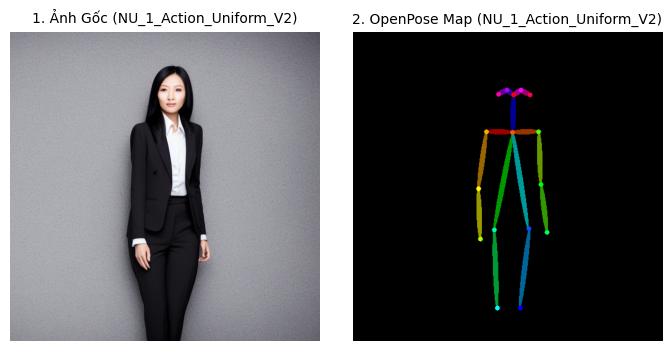

------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

-> Đã tạo và lưu Base Image & Pose Map cho NAM_2_Action_Uniform_V2
--- HIỂN THỊ KẾT QUẢ NẰM NGANG NAM_2_Action_Uniform_V2 ---


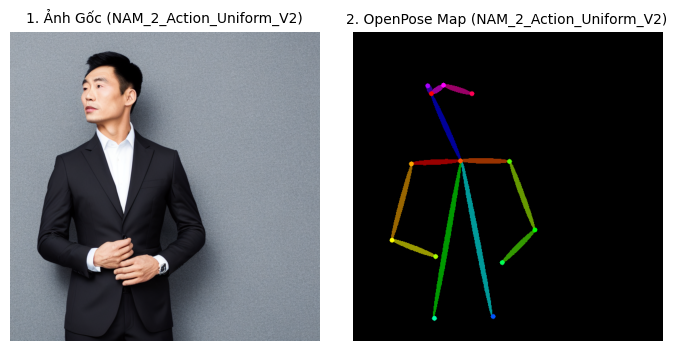

------------------------------

--- HOÀN TẤT CELL 2: ĐÃ CÓ ẢNH THAM CHIẾU VÀ OPENPOSE MAP ---


In [9]:
# @title 2. TẠO ẢNH THAM CHIẾU VÀ TRÍCH XUẤT OPENPOSE (Mô phỏng Cell 2)
import matplotlib.pyplot as plt
# --- CẤU HÌNH PROMPT GỐC ---
PROMPT_MAP = [
    (f"NU_1_Action_Uniform_V2", "NU", "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, clean modern studio background, hands on hips, torso leaning forward aggressively, challenging body language"),
    (f"NAM_2_Action_Uniform_V2", "NAM", "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, clean modern studio background, hands deeply set in pants pockets, shoulders slightly hunched, head tilted, defensive posture"),
    # (Thêm 8 cặp còn lại ở đây, nhưng chỉ cần chạy 2 cặp đầu để test nhanh)
    (f"NU_3_Action_Uniform_V2", "NU", "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, clean modern studio background, arms tightly crossed over chest, legs crossed, rejecting body language"),
    (f"NAM_4_Action_Uniform_V2", "NAM", "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, clean modern studio background, both palms turned outward in a gesture of honesty, pleading body posture"),
    # ... (Các tư thế khác)
]
# Giới hạn chỉ tạo 2 ảnh tham chiếu để test nhanh
PROMPT_MAP_LITE = PROMPT_MAP[:2]

NEG_PROMPT = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, furniture"
generator = torch.Generator(device).manual_seed(42)

print(f"BẮT ĐẦU TẠO {len(PROMPT_MAP_LITE)} ẢNH THAM CHIẾU GỐC VÀ OPENPOSE MAP...")

# --- THỰC HIỆN T2I ĐỂ TẠO ẢNH GỐC & TRÍCH XUẤT MAP ---
for file_prefix, gender, full_prompt in PROMPT_MAP_LITE:
    # 1. Tạo ảnh Gốc (Base Image)
    base_image = pipe(
        prompt=full_prompt,
        negative_prompt=NEG_PROMPT,
        num_inference_steps=50,
        guidance_scale=9.0,
        generator=generator,
        height=768, width=768
    ).images[0]

    # 2. Trích xuất OpenPose Map
    pose_image = openpose_detector(base_image)

    # 3. Lưu ảnh và Map
    base_image_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_base_image.png")
    pose_image_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_openpose.png")
    base_image.save(base_image_path)
    pose_image.save(pose_image_path)
    print(f"-> Đã tạo và lưu Base Image & Pose Map cho {file_prefix}")

    show_images(base_image, pose_image, file_prefix);

# --- TẢI 2 ẢNH THAM CHIẾU LÀM BIẾN TOÀN CỤC ---
try:
    REF_NU_PATH = os.path.join(OUTPUT_DIR, "NU_1_Action_Uniform_V2_base_image.png")
    REF_NAM_PATH = os.path.join(OUTPUT_DIR, "NAM_2_Action_Uniform_V2_base_image.png")

    globals()['REF_NU_IMAGE'] = Image.open(REF_NU_PATH).resize((768, 768)).convert("RGB")
    globals()['REF_NAM_IMAGE'] = Image.open(REF_NAM_PATH).resize((768, 768)).convert("RGB")
except Exception:
    print("!!! LỖI: Không tìm thấy ảnh tham chiếu. Kiểm tra lại việc tạo ảnh.")
    globals()['REF_NU_IMAGE'] = Image.new('RGB', (768, 768), color = 'black')
    globals()['REF_NAM_IMAGE'] = Image.new('RGB', (768, 768), color = 'black')

print("\n--- HOÀN TẤT CELL 2: ĐÃ CÓ ẢNH THAM CHIẾU VÀ OPENPOSE MAP ---")


--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---


  0%|          | 0/50 [00:00<?, ?it/s]

No model was supplied, defaulted to Intel/dpt-large and revision bc15f29 (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


-> Đã tạo và lưu ảnh nền cố định bằng AI tại: Pro_Auto_Pose_Output/AI_Generated_Background.png
-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


-> Đã trích xuất và chuẩn hóa Depth Map thành công.


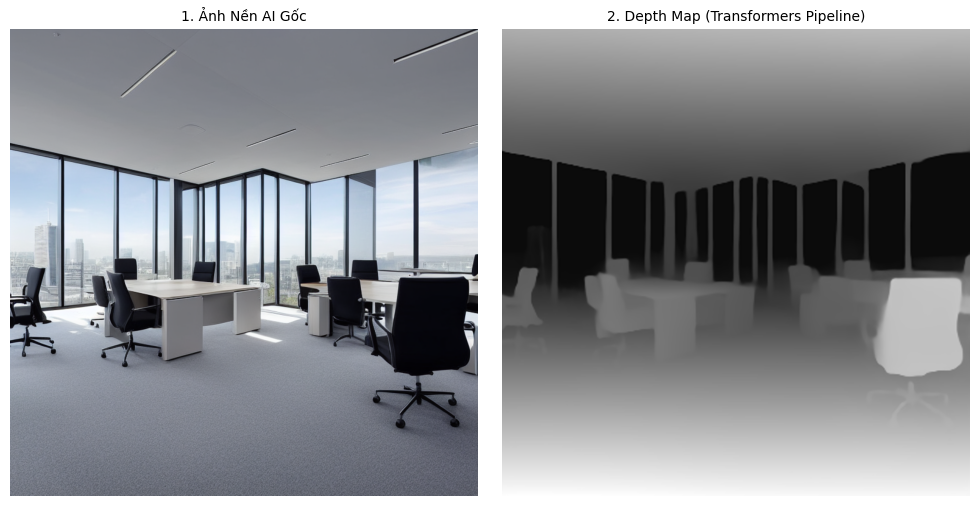


--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ TRANSFORMERS ---


In [10]:
# @title 3. TẠO ẢNH NỀN CỐ ĐỊNH BẰNG AI VÀ TRÍCH XUẤT DEPTH MAP (Sử dụng TRANSFORMERS)

# --- 1. CẤU HÌNH PROMPT TẠO ẢNH NỀN ---
BACKGROUND_PROMPT = "minimalist modern corporate office background, clean desk, executive chair, large window with soft sunlight, smooth polished floor, no visible person, centered composition, high quality"
NEG_BG_PROMPT = "person, people, blurry, low resolution, worst quality, out of focus, cartoon, illustration, cluttered"
BG_SEED = 12345

BG_DEPTH_MAP = None
print("--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---")

try:
    # 2. TẠO ẢNH NỀN BẰNG T2I (Dùng 'pipe' từ Cell 1)
    generator_bg = torch.Generator(device).manual_seed(BG_SEED)

    BG_IMAGE = pipe(
        prompt=BACKGROUND_PROMPT,
        negative_prompt=NEG_BG_PROMPT,
        num_inference_steps=50,
        guidance_scale=8.0,
        generator=generator_bg,
        height=768,
        width=768
    ).images[0]

    BG_IMAGE_PATH = os.path.join(os.environ['OUTPUT_DIR'], "AI_Generated_Background.png")
    BG_IMAGE.save(BG_IMAGE_PATH)
    print(f"-> Đã tạo và lưu ảnh nền cố định bằng AI tại: {BG_IMAGE_PATH}")

    # 3. TRÍCH XUẤT DEPTH MAP BẰNG TRANSFORMERS PIPELINE (FIX MỚI)
    print("-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...")

    # Khởi tạo Depth Pipeline của Transformers (chỉ trong Cell này)
    depth_estimator_pipeline = pipeline('depth-estimation', device=device)

    # Trích xuất Depth Map
    depth_result = depth_estimator_pipeline(BG_IMAGE)['depth']

    # Chuẩn hóa Depth Map để ControlNet có thể sử dụng (0-255 RGB)
    image_np = np.array(depth_result)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    # Chuyển đổi sang 3 kênh (ControlNet cần RGB)
    image_np = image_np[:, :, None]
    image_np = np.concatenate([image_np, image_np, image_np], axis=2)

    globals()['BG_DEPTH_MAP'] = Image.fromarray(image_np)
    print("-> Đã trích xuất và chuẩn hóa Depth Map thành công.")

    # 4. HIỂN THỊ KIỂM TRA
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(BG_IMAGE); axes[0].set_title("1. Ảnh Nền AI Gốc", fontsize=10); axes[0].axis('off')
    axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray'); axes[1].set_title("2. Depth Map (Transformers Pipeline)", fontsize=10); axes[1].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"!!! LỖI TẠO HOẶC XỬ LÝ ẢNH NỀN AI BẰNG TRANSFORMERS: {e}. Sử dụng Depth Map trung tính.")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white')

print("\n--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ TRANSFORMERS ---")


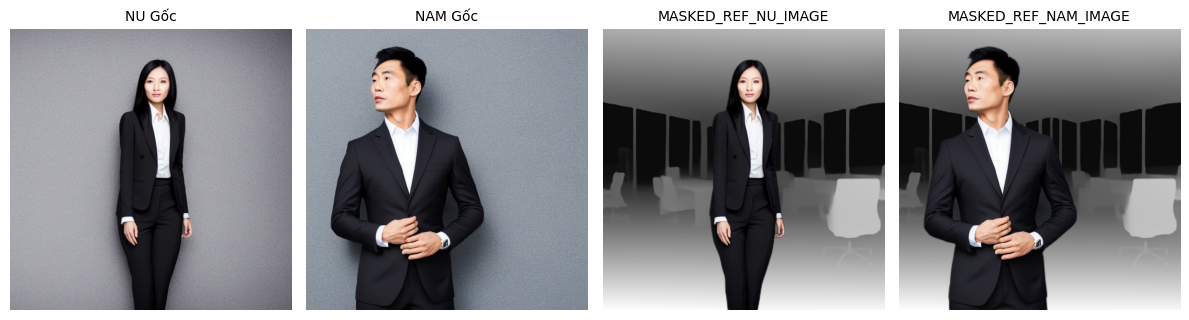

✅ Đã tách nền 2 nhân vật và gán thành hai biến riêng biệt.
MASKED_REF_NU_IMAGE và MASKED_REF_NAM_IMAGE đã sẵn sàng.


In [74]:
# @title 4b. Tách Nền và Giữ Tách Biệt 2 Nhân Vật (rembg - Đã Sửa Logic Gán)
# ⚡ Tạo hai ảnh masked riêng biệt: MASKED_REF_NU_IMAGE và MASKED_REF_NAM_IMAGE.

import os
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from rembg import remove

# --- CẤU HÌNH ---
TARGET_SIZE = (768, 768) # Kích thước ảnh tham chiếu gốc

# ------------------- HÀM CHÍNH (GIỮ NGUYÊN) -------------------
def remove_background_with_rembg(ref_image, target_size=(512,512), debug=False, save_prefix="ref_removed"):
    """
    Tách nền nhân vật bằng rembg (AI).
    Trả về ảnh RGB dán lên nền Depth Map (composed) và ảnh RGBA đã cắt (out_rgba).
    """
    ref_resized = ref_image.convert("RGB").resize(target_size, Image.LANCZOS)

    out_rgba = remove(ref_resized)
    if isinstance(out_rgba, (bytes, bytearray)):
        out_rgba = Image.open(io.BytesIO(out_rgba)).convert("RGBA")

    # Lấy nền Depth Map
    bg = None
    if "BG_DEPTH_MAP" in globals():
        # Quan trọng: resize BG_DEPTH_MAP về kích thước của ảnh tham chiếu
        bg = globals()["BG_DEPTH_MAP"].convert("RGB").resize(target_size, Image.LANCZOS)
    else:
        bg = Image.new("RGB", target_size, (230,230,230))

    composed = Image.alpha_composite(bg.convert("RGBA"), out_rgba).convert("RGB")

    # Lưu debug
    out_dir = os.environ.get("CONSISTENCY_DIR", ".")
    os.makedirs(out_dir, exist_ok=True)
    out_rgba.save(os.path.join(out_dir, f"{save_prefix}_cutout.png"))
    composed.save(os.path.join(out_dir, f"{save_prefix}_on_bg.png"))

    return composed, out_rgba

# ------------------- THỰC THI VỚI REF IMAGEs -------------------

# 1. Tách nền và gán kết quả cho NU (Nữ)
ref_nu = globals().get('REF_NU_IMAGE', None)
if ref_nu is None:
    raise RuntimeError("REF_NU_IMAGE not found in globals()")

composed_nu, cutout_nu = remove_background_with_rembg(
    ref_nu,
    target_size=TARGET_SIZE,
    debug=True,
    save_prefix="NU_ref_masked"
)
# GÁN BIẾN TOÀN CỤC MỚI CHO NU
globals()['MASKED_REF_NU_IMAGE'] = composed_nu


# 2. Tách nền và gán kết quả cho NAM (Nam)
ref_nam = globals().get('REF_NAM_IMAGE', None)
if ref_nam is None:
    raise RuntimeError("REF_NAM_IMAGE not found in globals()")

composed_nam, cutout_nam = remove_background_with_rembg(
    ref_nam,
    target_size=TARGET_SIZE,
    debug=True,
    save_prefix="NAM_ref_masked"
)
# GÁN BIẾN TOÀN CỤC MỚI CHO NAM
globals()['MASKED_REF_NAM_IMAGE'] = composed_nam

# GÁN THÊM BG_DEPTH_MAP CHO DỄ TRUY CẬP (Nếu đã có)
depth_map = globals().get('BG_DEPTH_MAP', None)
if depth_map:
    globals()['BG_DEPTH_MAP_RESIZED'] = depth_map.convert("RGB").resize(TARGET_SIZE, Image.LANCZOS)


# ------------------- HIỂN THỊ KẾT QUẢ -------------------
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(ref_nu)
plt.title("NU Gốc", fontsize=10)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(ref_nam)
plt.title("NAM Gốc", fontsize=10)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(composed_nu)
plt.title("MASKED_REF_NU_IMAGE", fontsize=10)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(composed_nam)
plt.title("MASKED_REF_NAM_IMAGE", fontsize=10)
plt.axis("off")

plt.tight_layout()
plt.show()

print("✅ Đã tách nền 2 nhân vật và gán thành hai biến riêng biệt.")
print(f"MASKED_REF_NU_IMAGE và MASKED_REF_NAM_IMAGE đã sẵn sàng.")

In [ ]:
# @title 4b. Tách Nền và Ghép 2 Nhân Vật Tham Chiếu Vao 1 cảnh (rembg - Đã Sửa Lỗi Logic)
# ⚡ Phiên bản nhẹ, chính xác, và đảm bảo nhân vật NAM + NU đều là tham chiếu.

import os
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from rembg import remove

# --- CẤU HÌNH ---
TARGET_SIZE = (512, 512) # Kích thước ảnh tham chiếu lớn hơn để giữ chi tiết (nếu VRAM cho phép)
OUTPUT_SIZE = (512, 512) # Kích thước cuối cùng của ảnh tham chiếu ghép (2 nhân vật)
OFFSET_X = 120 # Khoảng dịch chuyển ngang cho nhân vật thứ hai (để ghép)

# ------------------- HÀM TÁCH NỀN VÀ CẮT -------------------
def process_single_ref_image(ref_image, size, save_prefix):
    """Tách nền, cắt nhân vật, và trả về ảnh RGBA đã cắt."""
    print(f"-> Xử lý ảnh: {save_prefix}")

    # 1. Resize và Tách nền
    ref_resized = ref_image.convert("RGB").resize(size, Image.LANCZOS)
    out_rgba = remove(ref_resized)

    if isinstance(out_rgba, (bytes, bytearray)):
        out_rgba = Image.open(io.BytesIO(out_rgba)).convert("RGBA")

    # 2. Cắt ảnh (Crop) để loại bỏ khoảng trắng dư thừa
    # TÌM BOUNDING BOX CỦA NHÂN VẬT (Dựa trên kênh Alpha > 0)
    alpha = np.array(out_rgba.getchannel('A'))
    coords = np.argwhere(alpha > 0)
    if coords.size == 0:
        print(f"⚠️ Cảnh báo: Không tìm thấy nhân vật nào trong {save_prefix}.")
        return None

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Thêm lề (padding) 10-20%
    padding = int(min(size) * 0.15)

    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(size[0], x_max + padding)
    y_max = min(size[1], y_max + padding)

    # Crop ảnh
    cropped_rgba = out_rgba.crop((x_min, y_min, x_max, y_max))

    return cropped_rgba

# ------------------- HÀM GHÉP VÀ DÁN LÊN NỀN -------------------
def composite_two_characters(cropped_nu, cropped_nam, output_size, offset_x):
    """Ghép hai ảnh nhân vật đã cắt lên một nền Depth Map."""

    # 1. Chuẩn bị Canvas (Nền)
    target_width, target_height = output_size

    # Lấy nền Depth Map hoặc nền xám mặc định
    bg = None
    if "BG_DEPTH_MAP" in globals():
        # Resize BG_DEPTH_MAP về kích thước cuối cùng
        bg = globals()["BG_DEPTH_MAP"].convert("RGB").resize(output_size, Image.LANCZOS)
    else:
        bg = Image.new("RGB", output_size, (230,230,230))

    final_canvas = bg.convert("RGBA")

    # 2. Dán nhân vật NU (Nữ)
    if cropped_nu:
        # Resize nhân vật NU để đặt vừa vặn vào bên trái (ví dụ: 0 -> target_width/2)
        # Tỷ lệ 1:1 cho 2 nhân vật -> resize về 1/2 chiều rộng
        nu_size = (target_width // 2 - offset_x // 2, target_height)
        nu_resized = cropped_nu.resize(nu_size, Image.LANCZOS)

        # Vị trí dán NU (căn trái)
        nu_pos = (0, 0)
        final_canvas.paste(nu_resized, nu_pos, nu_resized)

    # 3. Dán nhân vật NAM (Nam)
    if cropped_nam:
        # Resize nhân vật NAM về cùng kích thước với NU
        nam_size = (target_width // 2 + offset_x // 2, target_height)
        nam_resized = cropped_nam.resize(nam_size, Image.LANCZOS)

        # Vị trí dán NAM (căn phải)
        # Bắt đầu dán từ giữa ảnh, dịch chuyển theo offset
        nam_pos = (target_width // 2 - offset_x, 0)
        final_canvas.paste(nam_resized, nam_pos, nam_resized)

    return final_canvas.convert("RGB")


# ------------------- THỰC THI VỚI REF IMAGEs -------------------
ref_nu = globals().get('REF_NU_IMAGE', None)
ref_nam = globals().get('REF_NAM_IMAGE', None)

if ref_nu is None or ref_nam is None:
  raise RuntimeError("REF_NU_IMAGE và/hoặc REF_NAM_IMAGE không tìm thấy trong globals().")

# 1. Xử lý tách nền riêng biệt
cropped_nu = process_single_ref_image(ref_nu, TARGET_SIZE, "NU_ref")
cropped_nam = process_single_ref_image(ref_nam, TARGET_SIZE, "NAM_ref")

# 2. Ghép hai ảnh đã cắt
if cropped_nu is None or cropped_nam is None:
    raise RuntimeError("Không thể tách nền một trong hai nhân vật.")

final_composite_rgba = composite_two_characters(cropped_nu, cropped_nam, OUTPUT_SIZE, OFFSET_X)

# Lưu kết quả
out_dir = os.environ.get("CONSISTENCY_DIR", ".")
os.makedirs(out_dir, exist_ok=True)
final_composite_rgba.save(os.path.join(out_dir, "FINAL_MASKED_COMPOSITE.png"))

# GÁN BIẾN TOÀN CỤC CHO CÁC CELL KHÁC
globals()['MASKED_REF_IMAGE'] = final_composite_rgba

# ------------------- HIỂN THỊ KẾT QUẢ -------------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(final_composite_rgba)
plt.title("Ảnh Tham Chiếu Ghép (NU + NAM) Final", fontsize=12)
plt.axis("off")

plt.subplot(1, 2, 2)
# Tạo một hình ảnh chỉ là cutout (trắng đen) để minh họa
mask_illustration = Image.new('RGB', OUTPUT_SIZE, (255, 255, 255))
if cropped_nu:
    nu_mask = cropped_nu.resize((OUTPUT_SIZE[0] // 2 - OFFSET_X // 2, OUTPUT_SIZE[1]), Image.NEAREST).convert("L")
    mask_illustration.paste(Image.new('RGB', nu_mask.size, (0, 0, 0)), (0, 0), nu_mask)
if cropped_nam:
    nam_mask = cropped_nam.resize((OUTPUT_SIZE[0] // 2 + OFFSET_X // 2, OUTPUT_SIZE[1]), Image.NEAREST).convert("L")
    mask_illustration.paste(Image.new('RGB', nam_mask.size, (0, 0, 0)), (OUTPUT_SIZE[0] // 2 - OFFSET_X, 0), nam_mask)

plt.imshow(mask_illustration)
plt.title("Minh họa Bố cục Mask", fontsize=12)
plt.axis("off")

plt.tight_layout()
plt.show()

print("✅ Đã tách nền 2 nhân vật, ghép và gán MASKED_REF_IMAGE.")
print("Kích thước tham chiếu cuối cùng:", OUTPUT_SIZE)
print("Kết quả lưu tại:", os.path.join(os.environ['CONSISTENCY_DIR'], "FINAL_MASKED_COMPOSITE.png"))

Mask meta: {'kernel': 71, 'percent': np.float64(0.24359130859375), 'final_percent': np.float64(0.2586127387152778)}


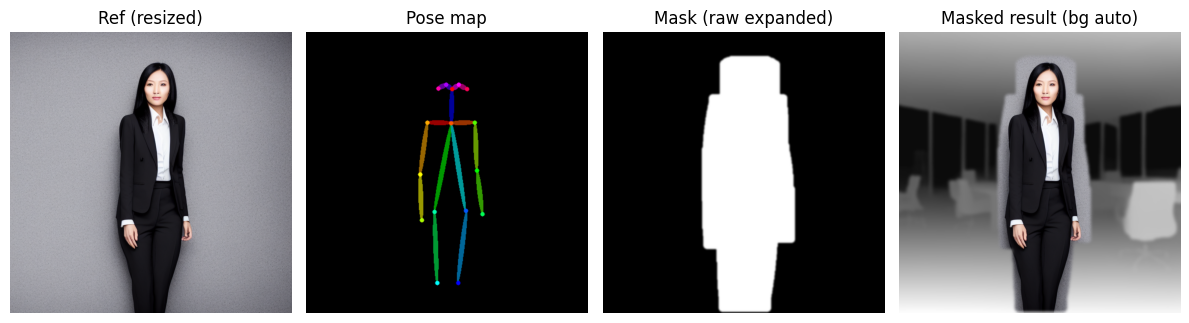

Saved debug images to CONSISTENCY_DIR


In [ ]:
# @title 4b. Xử Lý, Masking

# Cell: improved_mask_and_composite.py
import os
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt

# Try import cv2 for stronger morphology
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

def _sample_border_color(img_pil, sample_frac=0.05):
    """Estimate background color by sampling border pixels (returns (r,g,b))."""
    w, h = img_pil.size
    img = np.array(img_pil.convert("RGB"))
    pad_w = max(1, int(w * sample_frac))
    pad_h = max(1, int(h * sample_frac))
    # sample top, bottom, left, right strips
    strips = []
    strips.append(img[:pad_h, :, :].reshape(-1,3))
    strips.append(img[-pad_h:, :, :].reshape(-1,3))
    strips.append(img[:, :pad_w, :].reshape(-1,3))
    strips.append(img[:, -pad_w:, :].reshape(-1,3))
    stacked = np.concatenate(strips, axis=0)
    med = np.median(stacked, axis=0).astype(int)
    # slightly desaturate / brighten to be neutral
    med = np.clip(med * np.array([1.02,1.02,1.02]), 0, 255).astype(int)
    return tuple(med.tolist())

def expand_mask_cv2(mask_np, kernel_size, iterations=1, blur_radius=3, thresh_after=64, vertical_ratio=2.0):
    """Use cv2.dilate + optional blur to expand; supports vertical elongation."""
    h_kernel = int(kernel_size)
    v_kernel = int(kernel_size * vertical_ratio)
    kernel = np.ones((v_kernel, h_kernel), np.uint8)  # vertical stretched kernel
    dil = cv2.dilate(mask_np, kernel, iterations=iterations)
    if blur_radius and blur_radius > 0:
        dil = cv2.GaussianBlur(dil, (blur_radius * 2 + 1, blur_radius * 2 + 1), 0)
        _, dil = cv2.threshold(dil, thresh_after, 255, cv2.THRESH_BINARY)
    return dil


def expand_mask_pil(mask_img, expand_size=21, soften_radius=3):
    """Fallback method using PIL MaxFilter repeated to simulate dilation."""
    out = mask_img
    n = max(1, int(expand_size // 3))
    for _ in range(n):
        out = out.filter(ImageFilter.MaxFilter(3))
    if soften_radius and soften_radius>0:
        out = out.filter(ImageFilter.GaussianBlur(radius=soften_radius))
        arr = np.array(out)
        out = Image.fromarray(((arr>64).astype('uint8')*255)).convert("L")
    return out

def make_fullbody_mask_from_pose(pose_path, target_size=(768,768),
                                 method='auto', expand_start=21, expand_step=10,
                                 max_expand=81, blur_radius=3, min_percent=0.20):
    """
    Create a full-body mask from a skeleton/pose map by iteratively expanding
    until at least min_percent of image is covered or max_expand reached.
    Returns PIL L mask (0/255) and metadata.
    """
    pose = Image.open(pose_path).convert("RGB").resize(target_size, Image.NEAREST)
    gray = pose.convert("L")
    arr = np.array(gray)

    # initial tiny threshold to capture skeleton lines
    init = (arr > 6).astype('uint8') * 255
    init_img = Image.fromarray(init).convert("L")

    if method == 'auto':
        method = 'cv2' if HAS_CV2 else 'pil'

    best_mask = None
    best_meta = {}
    # iterate expanding kernel sizes
    for k in range(expand_start, max_expand + 1, expand_step):
        if method == 'cv2' and HAS_CV2:
            mask_np = expand_mask_cv2(init, kernel_size=k, iterations=1, blur_radius=blur_radius, thresh_after=64)
            mask_img = Image.fromarray(mask_np).convert("L")
        else:
            mask_img = expand_mask_pil(init_img, expand_size=k, soften_radius=blur_radius)

        percent = (np.array(mask_img) > 0).mean()
        best_mask = mask_img
        best_meta = {'kernel': k, 'percent': percent}
        # stop if reached target percent of the image
        if percent >= min_percent:
            break

    # do a final gentle gaussian blur to soften edges and keep mask as L (with soft edges)
    soft = best_mask.filter(ImageFilter.GaussianBlur(radius=2))
    # ensure values in 0..255 (PIL L)
    final_arr = np.array(soft)
    # normalize to 0..255
    final = Image.fromarray(((final_arr/ final_arr.max())*255).astype('uint8')) if final_arr.max()>0 else best_mask
    final = final.convert("L")
    best_meta['final_percent'] = (np.array(final)>0).mean()
    return final, best_meta

def create_masked_ref_image_refined(ref_image, pose_image_path, target_size=(768,768),
                                    bg_mode='auto', bg_color=None,
                                    method='auto', expand_start=21, expand_step=10,
                                    max_expand=81, blur_radius=3, min_percent=0.22,
                                    debug=False, save_prefix='debug_mask'):
    """
    Returns masked PIL RGB image (person preserved, background replaced).
    bg_mode: 'auto' (pick good bg color), 'color' (use bg_color), 'blur_depth' (if BG_DEPTH_MAP exists)
    If debug True returns (masked, mask_img, meta)
    """
    ref_resized = ref_image.convert("RGB").resize(target_size, Image.LANCZOS)

    # make mask
    mask_img, meta = make_fullbody_mask_from_pose(pose_image_path, target_size=target_size,
                                                  method=method, expand_start=expand_start,
                                                  expand_step=expand_step, max_expand=max_expand,
                                                  blur_radius=blur_radius, min_percent=min_percent)

    # pick background
    if bg_mode == 'color':
        if bg_color is None:
            bg_color = (230,230,230)  # soft light gray
        bg = Image.new("RGB", target_size, bg_color)
    elif bg_mode == 'blur_depth' and 'BG_DEPTH_MAP' in globals():
        # try to use BG_DEPTH_MAP as source background, blur it
        depth = globals()['BG_DEPTH_MAP']
        if isinstance(depth, np.ndarray):
            bg_img = Image.fromarray((depth*255).astype('uint8')) if depth.max()<=1.0 else Image.fromarray(depth.astype('uint8'))
        else:
            bg_img = depth
        bg = bg_img.convert("RGB").resize(target_size, Image.BILINEAR).filter(ImageFilter.GaussianBlur(radius=4))
    else:
        # auto: sample border color and make a slightly brighter/desaturated version or gradient
        sample_color = _sample_border_color(ref_resized)
        # lighten slightly
        bg = Image.new("RGB", target_size, tuple(np.clip(np.array(sample_color)+10,0,255).astype(int)))

    # Use softened mask for composite: make an alpha by blurring mask a bit
    alpha = mask_img.filter(ImageFilter.GaussianBlur(radius=3))
    # Ensure alpha is L (0..255)
    alpha = alpha.convert("L")

    # Composite using alpha: PIL.Image.composite expects hard mask, but we can alpha-blend manually
    # convert to arrays and blend: out = ref* (alpha/255) + bg*(1-alpha/255)
    ref_arr = np.array(ref_resized).astype('float32')
    bg_arr = np.array(bg).astype('float32')
    alpha_arr = np.array(alpha).astype('float32')/255.0
    alpha_arr = np.expand_dims(alpha_arr, axis=2)  # HxWx1
    comp = (ref_arr * alpha_arr + bg_arr * (1 - alpha_arr)).astype('uint8')
    masked = Image.fromarray(comp)

    # save debug images if requested
    out_dir = os.environ.get('CONSISTENCY_DIR', '.')
    os.makedirs(out_dir, exist_ok=True)
    masked.save(os.path.join(out_dir, f"{save_prefix}_masked.png"))
    mask_img.save(os.path.join(out_dir, f"{save_prefix}_mask_raw.png"))
    alpha.save(os.path.join(out_dir, f"{save_prefix}_mask_alpha.png"))
    if debug:
        return masked, mask_img, alpha, meta
    return masked

# ------------------- Example usage with your variables -------------------
pose_path = os.path.join(os.environ.get('OUTPUT_DIR','.'), 'NU_1_Action_Uniform_V2_openpose.png')
ref_image = globals().get('REF_NU_IMAGE', None)
if ref_image is None:
    raise RuntimeError("REF_NU_IMAGE not found in globals()")

# Try creating masked image with auto background selection
masked, mask_raw, mask_alpha, meta = create_masked_ref_image_refined(
    ref_image, pose_path, target_size=(768,768),
    bg_mode='blur_depth',      # 'color' or 'blur_depth' (if you have BG_DEPTH_MAP)
    method='auto',       # 'cv2' uses OpenCV if available
    expand_start=51, expand_step=20, max_expand=111,
    blur_radius=3, min_percent=0.22,
    debug=True, save_prefix='test_NU1'
)


# === GÁN BIẾN TOÀN CỤC CHO CELL KHÁC DÙNG ===
MASKED_REF_IMAGE = masked
MASK_RAW_IMAGE = mask_raw
MASK_ALPHA_IMAGE = mask_alpha



print("Mask meta:", meta)
plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(ref_image.convert("RGB").resize((768,768))); plt.title("Ref (resized)"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(Image.open(pose_path).convert("RGB").resize((768,768))); plt.title("Pose map"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(MASK_RAW_IMAGE, cmap='gray'); plt.title("Mask (raw expanded)"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(MASKED_REF_IMAGE); plt.title("Masked result (bg auto)"); plt.axis('off')
plt.tight_layout(); plt.show()

print("Saved debug images to CONSISTENCY_DIR")


In [4]:
# @title 4a. Khởi Tạo DUAL ControlNet Pipeline (Tách biệt Output Dài)
import torch
# Giả định: ControlNetModel, StableDiffusionImg2ImgPipeline, device, model_id đã được import.

# --- KHỞI TẠO PIPELINE ---
try:
    print("Đang tải các mô hình ControlNet...")
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # Tải lại Pipeline DUAL ControlNet
    # LƯU Ý: Đây là đoạn code sinh ra output dài, nó sẽ kết thúc tại đây.
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet]
    ).to(device)

    # ----------------------------------------------------
    # ⚡️ TỐI ƯU HÓA VRAM THIẾT YẾU CHO TÀI NGUYÊN HẠN CHẾ ⚡️
    # ----------------------------------------------------
    if device == "cuda":
        # 1. Tải thành phần mô hình sang CPU khi không sử dụng (CPU Offload)
        # Tắt .to(device) ở cuối nếu dùng offload, nhưng pipeline sẽ tự xử lý
        i2i_pipe.enable_model_cpu_offload()

        # 2. Tối ưu hóa bộ nhớ VRAM bằng Attention Slicing
        i2i_pipe.enable_attention_slicing()

        # 3. Sử dụng xFormers (nếu đã cài đặt thành công)
        i2i_pipe.enable_xformers_memory_efficient_attention()

    print("\n" * 3) # THÊM KHOẢNG TRỐNG ĐỂ NGẮT THÔNG BÁO DÀI
    print("✅ Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")

except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None

Đang tải các mô hình ControlNet...


Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]





✅ Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).


In [ ]:
# @title 4a. Khởi Tạo DUAL ControlNet Pipeline (Tối Ưu Nhẹ GPU)
import torch
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel

# --- KHỞI TẠO PIPELINE ---
try:
    print("Đang tải các mô hình ControlNet (OpenPose + Depth)...")

    pose_controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/control_v11p_sd15_openpose",
        torch_dtype=torch.float16
    )

    depth_controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/control_v11f1p_sd15_depth",
        torch_dtype=torch.float16
    )

    # --- TẠO PIPELINE DUAL CONTROLNET ---
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet],
        safety_checker=None     # 🚫 bỏ safety checker nếu bạn chỉ tạo nhân vật sạch
    )

    # --- ĐƯA PIPELINE LÊN GPU ---
    i2i_pipe.to(device)

    # ⚡️ TỐI ƯU HÓA VRAM CHO GPU NHỎ (6–12GB) ⚡️
    if device == "cuda":
        # 1️⃣ Attention slicing
        i2i_pipe.enable_attention_slicing()

        # 2️⃣ CPU Offload (tự đẩy bớt mô hình ra CPU khi không dùng)
        i2i_pipe.enable_model_cpu_offload()

        # 3️⃣ Tiết kiệm bộ nhớ cross-attention (xFormers)
        try:
            i2i_pipe.enable_xformers_memory_efficient_attention()
            print("✅ Đã bật xFormers.")
        except Exception:
            print("⚠️ Không bật được xFormers, nhưng pipeline vẫn hoạt động bình thường.")

        # 4️⃣ Giảm bộ nhớ tạm diffusion (thêm nữa)
        i2i_pipe.enable_vae_tiling()
        i2i_pipe.enable_vae_slicing()

    # --- DỌN BỘ NHỚ TẠM ---
    torch.cuda.empty_cache()

    print("\n✅ Đã tải xong DUAL ControlNet Pipeline (OpenPose + Depth).")
    print("📦 VRAM tối ưu hóa thành công, sẵn sàng cho cell 4c.")

except Exception as e:
    print(f"❌ Lỗi khởi tạo DUAL PIPELINE: {e}")
    i2i_pipe = None


In [51]:
# @title 3b. DỌN DẸP VRAM SAU KHI TẠO ẢNH NỀN VÀ DEPTH MAP
import torch
import gc

print("--- Giải phóng VRAM: Xóa mô hình Depth Estimation ---")

# 1. Xóa Depth Estimation Pipeline của Transformers
# Mô hình này chỉ dùng một lần trong Cell 3
try:
    del depth_estimator_pipeline
    print("-> Đã xóa depth_estimator_pipeline.")
except NameError:
    pass

# 2. Xóa các biến tạm thời lớn
try:
    # Xóa generator, ảnh nền gốc (giữ lại BG_DEPTH_MAP)
    del generator_bg, BG_IMAGE
    del depth_result, image_np
    print("-> Đã xóa các biến tạm thời lớn.")
except NameError:
    pass

# 3. Ép PyTorch trả lại bộ nhớ GPU (VRAM)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 4. Chạy Garbage Collector của Python
gc.collect()

print("✅ Đã dọn dẹp VRAM, sẵn sàng cho Cell 4a (tải ControlNet Pipeline).")

--- Giải phóng VRAM: Xóa mô hình Depth Estimation ---
✅ Đã dọn dẹp VRAM, sẵn sàng cho Cell 4a (tải ControlNet Pipeline).


In [ ]:
# @title 3b. DỌN DẸP VRAM SAU KHI TẠO ẢNH NỀN VÀ DEPTH MAP (Đã Bổ Sung)
import torch
import gc

print("--- Giải phóng VRAM: Xóa mô hình Depth Estimation ---")

# 1. Xóa Depth Estimation Pipeline và các thành phần liên quan
try:
    del depth_estimator_pipeline
    print("-> Đã xóa depth_estimator_pipeline.")
except NameError:
    pass

try:
    del depth_processor, depth_model
    print("-> Đã xóa depth_processor, depth_model (nếu tồn tại).")
except NameError:
    pass

# 2. Xóa các biến tạm thời lớn
try:
    # CHỈ XÓA CÁC BIẾN CỦA CELL 3
    del generator_bg, BG_IMAGE
    del depth_result, image_np, pipe_result
    print("-> Đã xóa các biến tạm thời lớn (Depth, BG).")
except NameError:
    pass

# 3. Ép PyTorch trả lại bộ nhớ GPU (VRAM)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 4. Chạy Garbage Collector của Python
gc.collect()

print("✅ Đã dọn dẹp VRAM, sẵn sàng cho Cell 4a (tải ControlNet Pipeline).")

In [15]:
# @title 4c. Xử Lý, Masking và Hiển Thị Kết Quả (Tối ưu hóa)
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# Giả định: globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP'],
# show_images (Cell 0), i2i_pipe (Cell 4a) đã được định nghĩa.


# --- THỰC HIỆN SẢN XUẤT ẢNH ---
PROMPT_MAP_FULL = [
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
]


CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET VÀ MASKING...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ['OUTPUT_DIR'], pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"


        # TỐI ƯU HÓA HIỂN THỊ TẠM THỜI: Dùng plt.figure trực tiếp
        print(f"--- HIỂN THỊ TẠM THỜI: Mask/Depth {i+1} ---")
        plt.figure(figsize=(7.0, 3.5))
        plt.subplot(1, 2, 1)
        plt.imshow(MASKED_REF_IMAGE)
        plt.title(f"1. Ref MASKED", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(globals()['BG_DEPTH_MAP'])
        plt.title(f"2. Depth Map", fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("-" * 30)

        generator = torch.Generator(device).manual_seed(200 + i)

        # GỌI DUAL CONTROLNET
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=MASKED_REF_IMAGE,
            control_image=[pose_image, globals()['BG_DEPTH_MAP']],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,
            strength=0.70,
            controlnet_conditioning_scale=[1.0, 1.5],
            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ TỔNG HỢP ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(os.environ['CONSISTENCY_DIR'], output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image, ref_image, masked_ref_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")

    # ----------------------------------------------------
    # --- HIỂN THỊ KẾT QUẢ CUỐI CÙNG (5 CỘT) ---
    # ----------------------------------------------------
    num_results = len(final_results)
    if num_results > 0:
        print("\n\n*** HIỂN THỊ KẾT QUẢ CUỐI CÙNG TỔNG HỢP ***")
        # 5 cột: OpenPose | Ref Gốc | Ref Masked | Depth Map | Final Image
        fig, axes = plt.subplots(num_results, 5, figsize=(25, 5 * num_results))
        axes = np.array(axes).ravel()

        if num_results == 1:
            axes = axes.reshape(1, 5)
        else:
            axes = axes.reshape(num_results, 5)

        for i, (prompt, pose_img, final_img, original_ref_img, masked_ref_img) in enumerate(final_results):
            # Cột 1: OpenPose
            axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"1. OpenPose", fontsize=10); axes[i, 0].axis('off')
            # Cột 2: Ref Gốc
            axes[i, 1].imshow(original_ref_img); axes[i, 1].set_title(f"2. Ref Gốc", fontsize=10); axes[i, 1].axis('off')
            # Cột 3: Ref MASKED
            axes[i, 2].imshow(MASKED_REF_IMAGE); axes[i, 2].set_title(f"3. Ref MASKED", fontsize=10); axes[i, 2].axis('off')
            # Cột 4: Depth Map
            axes[i, 3].imshow(globals()['BG_DEPTH_MAP']); axes[i, 3].set_title("4. Depth Map", fontsize=10); axes[i, 3].axis('off')
            # Cột 5: ẢNH CUỐI CÙNG
            axes[i, 4].imshow(final_img); axes[i, 4].set_title(f"5. ẢNH CUỐI CÙNG", fontsize=10, color='red'); axes[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    print("\n--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")


# Debug quick-check: in các biến quan trọng và liệt kê files trong OUTPUT_DIR
print(">>> DEBUG: Kiểm tra biến môi trường và file")
print("OUTPUT_DIR:", os.environ.get('OUTPUT_DIR'))
print("CONSISTENCY_DIR:", os.environ.get('CONSISTENCY_DIR'))
print("i2i_pipe is None?", i2i_pipe is None)
try:
    import torch
    print("torch available, version:", torch.__version__)
    print("device var in globals():", 'device' in globals())
except Exception as e:
    print("torch import err:", e)

out_dir = os.environ.get('OUTPUT_DIR')
if out_dir and os.path.exists(out_dir):
    print("Files in OUTPUT_DIR (head):", os.listdir(out_dir)[:50])
else:
    print("OUTPUT_DIR không tồn tại hoặc chưa set đúng.")

# Kiểm tra từng pose file path theo PROMPT_MAP_FULL
for pose_file, gender, _ in PROMPT_MAP_FULL:
    pose_path = os.path.join(os.environ.get('OUTPUT_DIR',''), pose_file)
    print(pose_file, "->", pose_path, "exists?", os.path.isfile(pose_path))



BẮT ĐẦU TẠO 2 ẢNH VỚI DUAL CONTROLNET VÀ MASKING...


  0%|          | 0/19 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.62 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.38 GiB is free. Process 222451 has 12.35 GiB memory in use. Of the allocated memory 12.12 GiB is allocated by PyTorch, and 74.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


--- Xử lý 1/2: NU_1_Action_Uniform_V2_openpose.png (NU) ---
Prompt: A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered, hands on hips, professional posture, full body pose


  0%|          | 0/30 [00:00<?, ?it/s]

-> Đã tạo và lưu: Pro_Consistency_Output/Final_Pose_1_NU_FINAL_IMAGE.png

--- Xử lý 2/2: NAM_2_Action_Uniform_V2_openpose.png (NAM) ---
Prompt: A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered, hands deeply set in pants pockets, head tilted, defensive posture


  0%|          | 0/30 [00:00<?, ?it/s]

-> Đã tạo và lưu: Pro_Consistency_Output/Final_Pose_2_NAM_FINAL_IMAGE.png

📊 HIỂN THỊ KẾT QUẢ CUỐI:


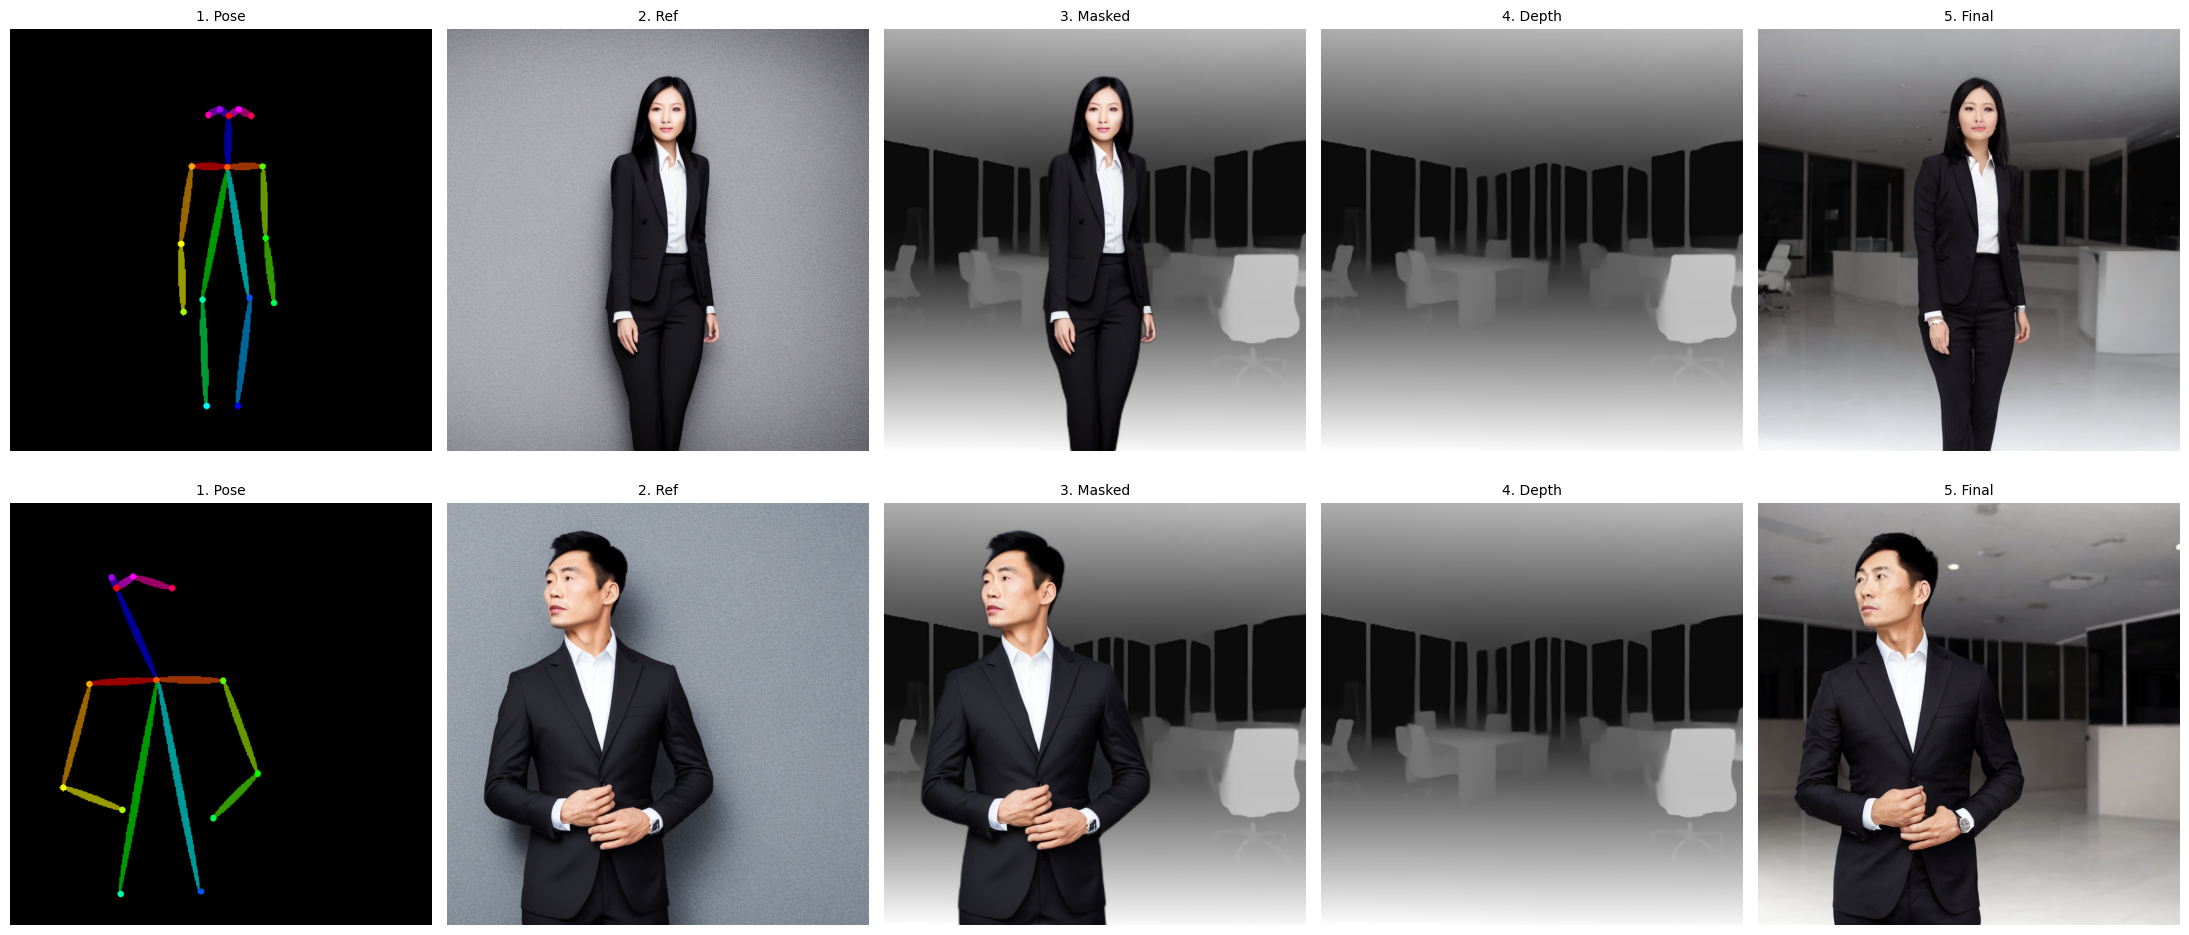


✅ HOÀN TẤT CELL 4C (Tối ưu VRAM).


In [79]:
# @title 4c. Xử Lý, Masking và Hiển Thị Kết Quả (Tối ưu hóa - phiên bản tiết kiệm VRAM)
import os, gc, torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Giả định: globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP'],
# globals()['MASKED_REF_IMAGE'], i2i_pipe, device, model_id đã được định nghĩa trước đó.

# --- CẤU HÌNH TỐI ƯU ---
TARGET_SIZE = (768, 768)        # giảm kích thước (384 tốt cho GPU 8-12GB)
STEPS = 50                      # num_inference_steps (giảm từ 30->20 nếu cần nhẹ hơn)
GUIDANCE = 7.0                  # guidance_scale
STRENGTH = 0.60                 # strength cho img2img
CONTROLNET_SCALES = [1.2, 1.2]  # conditioning scales

# Prompt map (giữ nguyên)
PROMPT_MAP_FULL = [
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
]

CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

# Kiểm tra pipeline
if i2i_pipe is None:
    print("❌ Pipeline chưa khởi tạo. Dừng Cell 4c.")
else:
    # # Cố gắng bật sequential cpu offload nếu có
    # try:
    #     i2i_pipe.enable_sequential_cpu_offload()
    #     print("✅ Bật enable_sequential_cpu_offload() để giảm peak VRAM.")
    # except Exception:
    #     # fallback: ensure attention slicing and model cpu offload (nếu có)
    #     try:
    #         i2i_pipe.enable_attention_slicing()
    #         i2i_pipe.enable_model_cpu_offload()
    #         print("⚠️ Sequential offload không hỗ trợ, đã bật attention_slicing + model_cpu_offload.")
    #     except Exception:
    #         print("⚠️ Không bật được chế độ offload; tiến hành các tối ưu khác.")

    final_results = []

    # Resize common inputs once (to TARGET_SIZE) to minimize repeated work
    # -------------------------------------------------------------------

    # masked_ref_global = globals().get('MASKED_REF_NU_IMAGE', None)
    # if masked_ref_global is None:
    #     raise RuntimeError("MASKED_REF_IMAGE không tồn tại trong globals(). Chạy cell tách nền trước.")
    # masked_ref_resized = masked_ref_global.convert("RGB").resize(TARGET_SIZE, Image.LANCZOS)


    depth_map = globals().get('BG_DEPTH_MAP', None)
    if depth_map is None:
        # fallback màu nền
        depth_resized = Image.new("RGB", TARGET_SIZE, (230,230,230))
    else:
        depth_resized = depth_map.convert("RGB").resize(TARGET_SIZE, Image.BILINEAR)

    # Loop qua các pose
    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ.get('OUTPUT_DIR','.'), pose_file)
        if not os.path.exists(pose_path):
            print(f"⚠️ Bỏ qua, không thấy pose: {pose_path}")
            continue

        # ❗ KHỐI CODE ĐÃ SỬA: CHỌN VÀ RESIZE ẢNH THAM CHIẾU THEO GIỚI TÍNH ❗
        if gender == "NU":
            # Lấy ảnh tham chiếu đã mask của Nữ (từ Cell 4b)
            masked_ref_to_use = globals().get('MASKED_REF_NU_IMAGE', None)
        else: # gender == "NAM"
            # Lấy ảnh tham chiếu đã mask của Nam (từ Cell 4b)
            masked_ref_to_use = globals().get('MASKED_REF_NAM_IMAGE', None)

        if masked_ref_to_use is None:
            print(f"❌ Không tìm thấy ảnh tham chiếu mask cho {gender}. Bỏ qua.")
            continue

        # Resize ảnh tham chiếu đã mask về TARGET_SIZE
        masked_ref_resized = masked_ref_to_use.convert("RGB").resize(TARGET_SIZE, Image.LANCZOS)
        # ---------------------------------------------------

        # Resize pose
        pose_image = Image.open(pose_path).convert("RGB").resize(TARGET_SIZE, Image.NEAREST)
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        prompt_text = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        print(f"\n--- Xử lý {i+1}/{len(PROMPT_MAP_FULL)}: {pose_file} ({gender}) ---")
        print("Prompt:", prompt_text)

        # Use mixed precision context if CUDA available
        # from contextlib import nullcontext
        # autocast_ctx = nullcontext()  # ❗Không dùng autocast FP16 khi có sequential_cpu_offload



        # with autocast_ctx:
        generator = torch.Generator(device).manual_seed(200 + i) if device == "cuda" else None

        out = i2i_pipe(
            prompt=prompt_text,
            image=masked_ref_resized,
            control_image=[pose_image, depth_resized],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=STEPS,
            guidance_scale=GUIDANCE,
            strength=STRENGTH,
            controlnet_conditioning_scale=CONTROLNET_SCALES,
            generator=generator
        ).images[0]

        # Save result
        out_name = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        out_path = os.path.join(os.environ.get('CONSISTENCY_DIR','.'), out_name)
        out.save(out_path)
        print("-> Đã tạo và lưu:", out_path)

        # append to final results (store resized inputs for display)
        final_results.append((prompt_text, pose_image.copy(), out.copy(), ref_image.copy(), masked_ref_resized.copy()))

        # --- Giải phóng kỹ lưỡng ---
        try:
            del out, generator
        except Exception:
            pass

        torch.cuda.empty_cache()
        gc.collect()

    # Hiển thị gọn kết quả cuối cùng (nếu có)
    if len(final_results) > 0:
        print("\n📊 HIỂN THỊ KẾT QUẢ CUỐI:")
        rows = len(final_results)
        fig, axes = plt.subplots(rows, 5, figsize=(22, 5*rows))
        if rows == 1:
            axes = np.expand_dims(axes, 0)
        for i, (prompt, pose_img, final_img, ref_img, masked_img) in enumerate(final_results):
            imgs = [pose_img, ref_img.resize(TARGET_SIZE), masked_img, depth_resized, final_img]
            titles = ["1. Pose", "2. Ref", "3. Masked", "4. Depth", "5. Final"]
            for j in range(5):
                axes[i, j].imshow(imgs[j])
                axes[i, j].set_title(titles[j], fontsize=10)
                axes[i, j].axis("off")
        plt.tight_layout(); plt.show()

    print("\n✅ HOÀN TẤT CELL 4C (Tối ưu VRAM).")


In [ ]:
# @title 5. DỌN DẸP VRAM VÀ RAM CUỐI CÙNG (Sau khi tạo ảnh)
import torch
import gc

print("--- BẮT ĐẦU DỌN DẸP CUỐI CÙNG: Giải phóng Pipeline và Ảnh tham chiếu ---")

# 1. XÓA PIPELINE LỚN NHẤT (VRAM)
try:
    # Xóa toàn bộ Diffusers pipeline (ControleNet + Stable Diffusion)
    del i2i_pipe
    print("-> Đã xóa i2i_pipe (Giảm VRAM lớn nhất).")
except NameError:
    pass

# 2. XÓA CÁC ẢNH THAM CHIẾU VÀ ĐÃ MASK (RAM)
try:
    # Xóa ảnh gốc
    del globals()['REF_NU_IMAGE']
    del globals()['REF_NAM_IMAGE']
    print("-> Đã xóa ảnh tham chiếu gốc (REF_NU_IMAGE, REF_NAM_IMAGE).")
except (NameError, KeyError):
    pass

try:
    # Xóa ảnh đã xử lý Masking
    del globals()['MASKED_REF_NU_IMAGE']
    del globals()['MASKED_REF_NAM_IMAGE']
    print("-> Đã xóa ảnh đã Mask (MASKED_REF_NU_IMAGE, MASKED_REF_NAM_IMAGE).")
except (NameError, KeyError):
    pass

# 3. XÓA ẢNH NỀN VÀ KẾT QUẢ TẠM THỜI (RAM)
try:
    del globals()['BG_DEPTH_MAP']
    del final_results
    print("-> Đã xóa BG_DEPTH_MAP và final_results.")
except (NameError, KeyError):
    pass

# 4. GIẢI PHÓNG BỘ NHỚ HỆ THỐNG
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("-> Đã ép PyTorch giải phóng bộ nhớ CUDA (VRAM).")

gc.collect()
print("-> Đã chạy Garbage Collector (RAM).")

print("\n✅ HOÀN TẤT DỌN DẸP VRAM/RAM. Sổ tay đã trở về trạng thái tối ưu bộ nhớ.")

In [ ]:
# @title 5.1 - HIỂN THỊ KẾT QUẢ VÀ TINH CHỈNH (Refinement)

# --- HIỂN THỊ TỔNG QUAN KẾT QUẢ CUỐI CÙNG ---
num_results = len(final_results)
if num_results > 0:
    # Hiển thị so sánh: Pose | Ref Image | Final Image
    cols = 3
    rows = num_results
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    if rows == 1: axes = np.array([axes]) # Dùng cho trường hợp chỉ có 1 kết quả

    for i, (prompt, pose_img, final_img) in enumerate(final_results):
        # Cột 1: OpenPose Map
        axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')

        # Cột 2: Ảnh Tham chiếu
        ref_image = globals()['REF_NU_IMAGE'] if 'NU' in prompt else globals()['REF_NAM_IMAGE']
        axes[i, 1].imshow(ref_image); axes[i, 1].set_title(f"Ref Image ({'Nữ' if 'NU' in prompt else 'Nam'})", fontsize=10); axes[i, 1].axis('off')

        # Cột 3: Ảnh Cuối cùng (Đã Đồng nhất)
        axes[i, 2].imshow(final_img); axes[i, 2].set_title(f"Ảnh Cuối cùng (Đã Đồng nhất - Dual CN)", fontsize=10); axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# --- [TÙY CHỌN] TINH CHỈNH BẰNG CONTROLNET CANNY ---
# Chỉ chạy Canny cho ảnh cuối cùng của Nữ (NU_1) và Nam (NAM_2) để minh họa
print("\n--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---")

files_to_refine = [f for f in os.listdir(CONSISTENCY_DIR) if f.startswith('Final_Pose_1_NU') or f.startswith('Final_Pose_2_NAM')]

if files_to_refine:
    try:
        # Tải Pipeline I2I kết hợp ControlNet Canny
        canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16).to(device)
        canny_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, controlnet=canny_controlnet, torch_dtype=torch.float16).to(device)
        if device == "cuda": canny_pipe.enable_xformers_memory_efficient_attention()

        for filename in files_to_refine:
            original_path = os.path.join(CONSISTENCY_DIR, filename)
            original_image = Image.open(original_path).convert("RGB")

            # Trích xuất Canny Map
            canny_map = canny_detector(original_image, low_threshold=100, high_threshold=200)

            # Chạy Refinement
            refined_image = canny_pipe(
                prompt="ultra detailed, high-detail photorealistic, professional photography, 8k",
                image=original_image, control_image=canny_map,
                negative_prompt="blurry, low quality, deformed, out of focus",
                num_inference_steps=30,
                guidance_scale=7.0,
                strength=0.5, # Strength thấp để giữ nguyên ảnh gốc
                controlnet_conditioning_scale=0.8,
                generator=torch.Generator(device).manual_seed(999)
            ).images[0]

            # Hiển thị so sánh
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_image); axes[0].set_title("1. Ảnh Gốc (Cell 4)"); axes[0].axis('off')
            axes[1].imshow(canny_map, cmap='gray'); axes[1].set_title("2. Canny Map"); axes[1].axis('off')
            axes[2].imshow(refined_image); axes[2].set_title("3. Ảnh Tinh Chỉnh (Refined)"); axes[2].axis('off')
            plt.show()

    except Exception as e:
        print(f"\n!!! LỖI TRONG PHẦN TINH CHỈNH CONTROLNET CANNY: {e}")

print("\n--- HOÀN TẤT CELL 5: QUY TRÌNH KẾT THÚC ---")



--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 21c933d1-9914-478d-9237-eee037b8307d)')' thrown while requesting HEAD https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/model_index.json
Retrying in 1s [Retry 1/5].
Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


!!! LỖI TRONG PHẦN TINH CHỈNH CONTROLNET CANNY: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 4151 has 14.73 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 69.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- HOÀN TẤT CELL 5: QUY TRÌNH KẾT THÚC ---


In [ ]:
# @title 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET (FIX CUỐI: MASKING ẢNH REF VÀ HIỂN THỊ CHẮC CHẮN)

import torch
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Import để đảm bảo hiển thị hình ảnh

# Giả định các biến sau đã được thiết lập trong các Cell trước:
# device, model_id, globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP']
# os.environ['OUTPUT_DIR'], os.environ['CONSISTENCY_DIR']

# --- KHỞI TẠO PIPELINE (DUAL CONTROLNET) ---
try:
    # Tải ControlNet Model (Pose)
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)
    # Tải ControlNet Model (Depth)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # Tải Pipeline với LIST ControlNet
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet] # LIST ControlNet Models
    ).to(device)
    if device == "cuda":
        # Tải lại Xformers nếu cần thiết
        try:
            i2i_pipe.enable_xformers_memory_efficient_attention()
        except Exception:
            pass # Bỏ qua lỗi nếu không thể kích hoạt
    print("Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")
except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None

# --- HÀM TẠO MASK TRÊN ẢNH REF (FIX Lỗi Nền) ---
def create_masked_ref_image(ref_image, pose_image_path):
    """Sử dụng OpenPose Map để mask ảnh ref, che bối cảnh bằng màu trung tính."""

    # 1. Tải OpenPose Map
    pose_mask_img = Image.open(pose_image_path).convert("RGB")

    pose_mask_img = pose_mask_img.resize(ref_image.size, Image.NEAREST)

    # 2. Tạo Mask: Tìm các pixel có màu (xương/khớp), biến chúng thành mask
    mask_np = np.array(pose_mask_img)
    # Vùng có dữ liệu pose (Màu không phải đen [0,0,0])
    is_person = (mask_np[:, :, 0] > 0) | (mask_np[:, :, 1] > 0) | (mask_np[:, :, 2] > 0)

    # 3. Áp dụng Mask lên ảnh Ref
    ref_np = np.array(ref_image).copy()

    # Đặt vùng bối cảnh (không phải người) thành màu trung tính (Xám: 128)
    ref_np[~is_person] = 128

    return Image.fromarray(ref_np)

# --- THỰC HIỆN SẢN XUẤT ẢNH ---
PROMPT_MAP_FULL = [
    ("NU_1_Ref_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Ref_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
    ("NU_3_NewPose_openpose.png", "NU", "looking at camera, one hand pointing directly"),
    ("NAM_4_NewPose_openpose.png", "NAM", "confident standing pose, leaning against a clean white desk"),
]
CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET VÀ MASKING...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ['OUTPUT_DIR'], pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        # BƯỚC MASKING CHỦ ĐỘNG
        masked_ref_image = create_masked_ref_image(ref_image, pose_path)

        generator = torch.Generator(device).manual_seed(200 + i)

        # GỌI DUAL CONTROLNET
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=masked_ref_image, # <-- Dùng ảnh đã được che nền
            control_image=[pose_image, globals()['BG_DEPTH_MAP']],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,

            strength=0.70, # Giữ mức này để giữ nhân vật, nhưng bối cảnh đã bị che sẽ dễ dàng thay đổi
            controlnet_conditioning_scale=[1.0, 1.5], # Tăng cường ảnh hưởng của Depth Map

            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ TỔNG HỢP ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(os.environ['CONSISTENCY_DIR'], output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image, masked_ref_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")

    # ----------------------------------------------------
    # --- HIỂN THỊ KẾT QUẢ CUỐI CÙNG (SỬ DỤNG IPython.display) ---
    # ----------------------------------------------------
    num_results = len(final_results)
    if num_results > 0:

        # Thay đổi số cột thành 4 để hiển thị thêm ảnh REF GỐC
        fig, axes = plt.subplots(num_results, 4, figsize=(20, 5 * num_results))
        # Xử lý trường hợp chỉ có 1 kết quả
        axes = np.array(axes).reshape(-1, 4)

        for i, (prompt, pose_img, final_img, masked_ref_img) in enumerate(final_results):
            axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')
            axes[i, 1].imshow(masked_ref_img); axes[i, 1].set_title(f"Ref Image (Đã MASK Bối cảnh)", fontsize=10); axes[i, 1].axis('off')
            # Thêm ảnh Depth Map (từ biến toàn cục) vào cột 3
            axes[i, 2].imshow(globals()['BG_DEPTH_MAP']); axes[i, 2].set_title("Depth Map Bối cảnh", fontsize=10); axes[i, 2].axis('off')
            axes[i, 3].imshow(final_img); axes[i, 3].set_title(f"ẢNH CUỐI CÙNG", fontsize=10, color='red'); axes[i, 3].axis('off')

        plt.tight_layout()

        # SỬA LỖI KHÔNG HIỂN THỊ
        display(fig)
        plt.close(fig) # Đóng figure

    print("\n--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")


Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).

BẮT ĐẦU TẠO 4 ẢNH VỚI DUAL CONTROLNET VÀ MASKING...

--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---


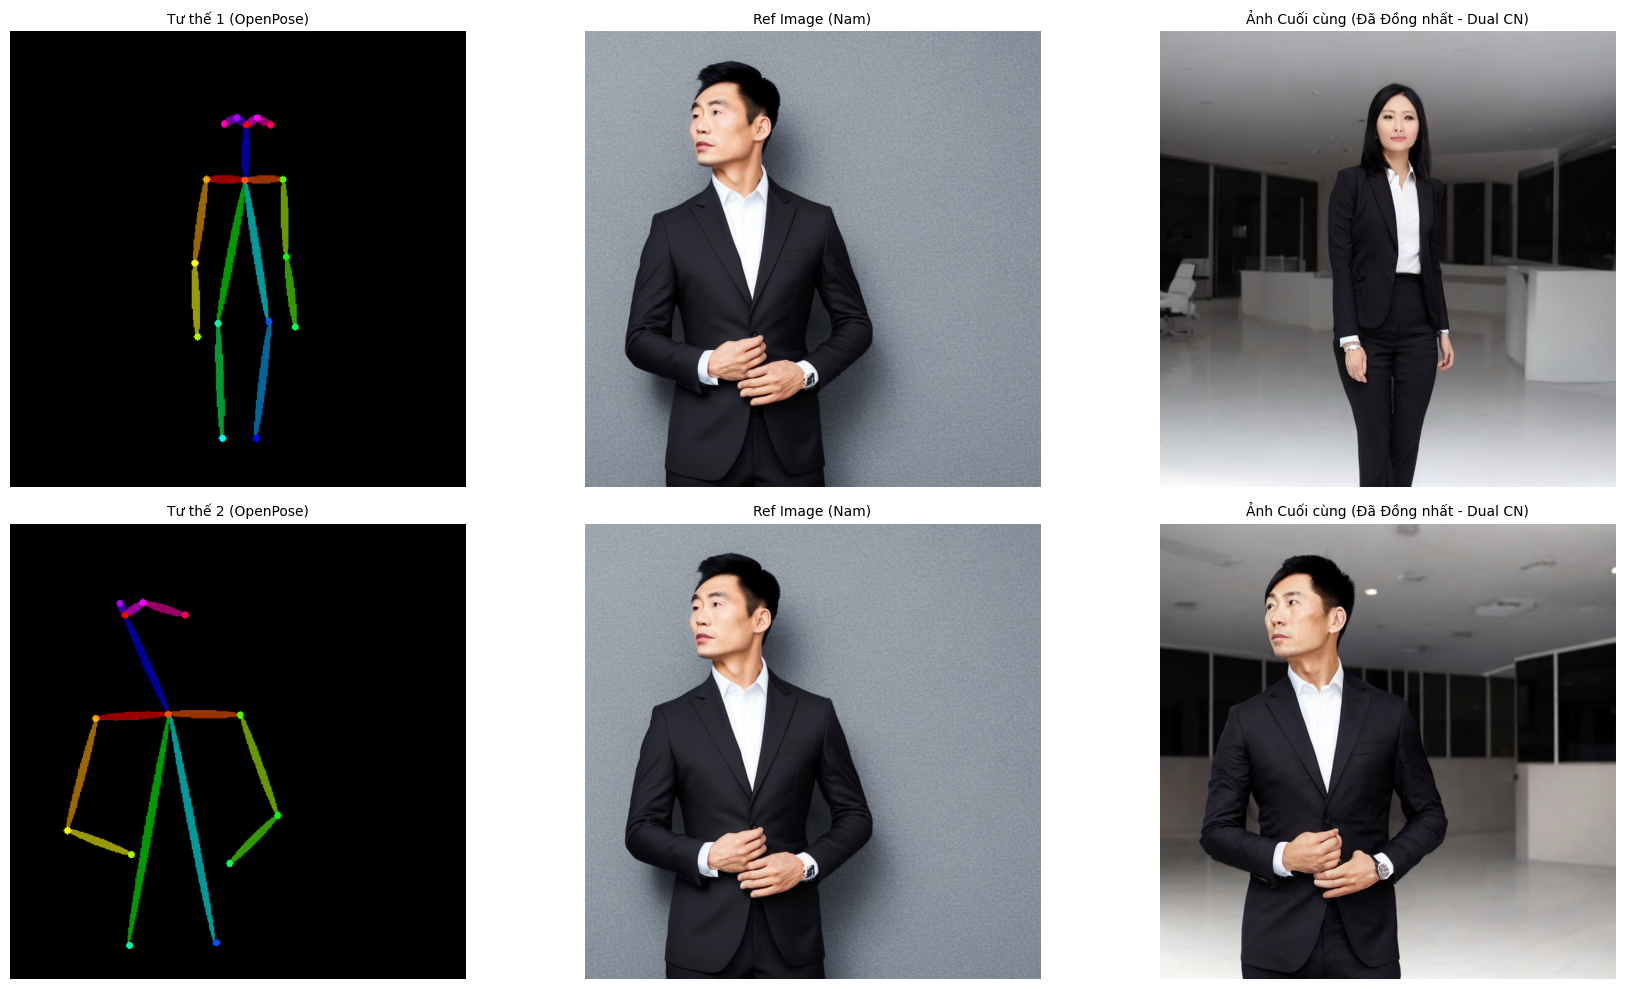

✅ Hoàn tất hiển thị kết quả tổng quan.


In [80]:
# @title 5.1. HIỂN THỊ KẾT QUẢ TỔNG QUAN (OpenPose | Ref Image | Final Image)
import matplotlib.pyplot as plt
import numpy as np

# Giả định: final_results, globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'] đã tồn tại

# --- HIỂN THỊ TỔNG QUAN KẾT QUẢ CUỐI CÙNG ---
num_results = len(final_results)
if num_results > 0:
    # Hiển thị so sánh: Pose | Ref Image | Final Image
    cols = 3
    rows = num_results
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    if rows == 1: axes = np.array([axes]) # Dùng cho trường hợp chỉ có 1 kết quả

    # final_results có cấu trúc: (prompt, pose_img, final_img, ref_image, masked_img)
    # LƯU Ý: prompt trong final_results có chứa 'NU' hoặc 'NAM'
    for i, (prompt, pose_img, final_img, _, _) in enumerate(final_results):
        # Cột 1: OpenPose Map (lấy từ final_results[1])
        axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')

        # Cột 2: Ảnh Tham chiếu Gốc (Lấy từ globals())
        ref_image = globals()['REF_NU_IMAGE'] if 'NU' in prompt else globals()['REF_NAM_IMAGE']
        axes[i, 1].imshow(ref_image); axes[i, 1].set_title(f"Ref Image ({'Nữ' if 'NU' in prompt else 'Nam'})", fontsize=10); axes[i, 1].axis('off')

        # Cột 3: Ảnh Cuối cùng (Đã Đồng nhất) (lấy từ final_results[2])
        axes[i, 2].imshow(final_img); axes[i, 2].set_title(f"Ảnh Cuối cùng (Đã Đồng nhất - Dual CN)", fontsize=10); axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Không có kết quả nào để hiển thị. Vui lòng kiểm tra lại Cell 4c.")

print("✅ Hoàn tất hiển thị kết quả tổng quan.")

In [81]:
# @title 5.2. CÀI ĐẶT CONTROLNET CANNY VÀ CÁC THÀNH PHẦN
import torch
import gc
from diffusers import ControlNetModel, StableDiffusionImg2ImgPipeline
from controlnet_aux import CannyDetector # Giả định thư viện này đã được cài đặt

print("--- BẮT ĐẦU CÀI ĐẶT TINH CHỈNH CANNY ---")

# Kiểm tra device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Giả định: model_id đã được định nghĩa trước (ví dụ: 'runwayml/stable-diffusion-v1-5')
if 'model_id' not in globals():
    model_id = "runwayml/stable-diffusion-v1-5"
    print(f"⚠️ model_id chưa được định nghĩa, sử dụng fallback: {model_id}")

try:
    # 1. Tải ControlNet Canny Model (VRAM)
    canny_controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/control_v11p_sd15_canny",
        torch_dtype=torch.float16
    ).to(device)
    print("-> Đã tải ControlNet Canny Model.")

    # 2. Tải Stable Diffusion I2I Pipeline kết hợp Canny ControlNet
    canny_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        controlnet=canny_controlnet,
        torch_dtype=torch.float16
    ).to(device)
    print(f"-> Đã tải StableDiffusionImg2ImgPipeline (Base: {model_id}).")

    # 3. Khởi tạo Canny Detector (CPU/RAM)
    canny_detector = CannyDetector()
    print("-> Đã khởi tạo Canny Detector.")

    if device == "cuda":
        canny_pipe.enable_xformers_memory_efficient_attention()
        torch.cuda.empty_cache()

    # Gán biến toàn cục để sử dụng ở Cell 5.3
    globals()['canny_pipe'] = canny_pipe
    globals()['canny_detector'] = canny_detector

    print("\n✅ Hoàn tất cài đặt Canny Refinement.")

except Exception as e:
    print(f"\n!!! LỖI TẢI CONTROLNET CANNY: {e}")
    globals()['canny_pipe'] = None
    globals()['canny_detector'] = None

--- BẮT ĐẦU CÀI ĐẶT TINH CHỈNH CANNY ---


config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

-> Đã tải ControlNet Canny Model.


Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
   

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

-> Đã tải StableDiffusionImg2ImgPipeline (Base: runwayml/stable-diffusion-v1-5).
-> Đã khởi tạo Canny Detector.

✅ Hoàn tất cài đặt Canny Refinement.


--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---

-> Tinh chỉnh file: Final_Pose_1_NU_FINAL_IMAGE.png


  0%|          | 0/15 [00:00<?, ?it/s]

-> Đã lưu ảnh tinh chỉnh: Pro_Consistency_Output/Final_Pose_1_NU_FINAL_IMAGE_REFINED.png


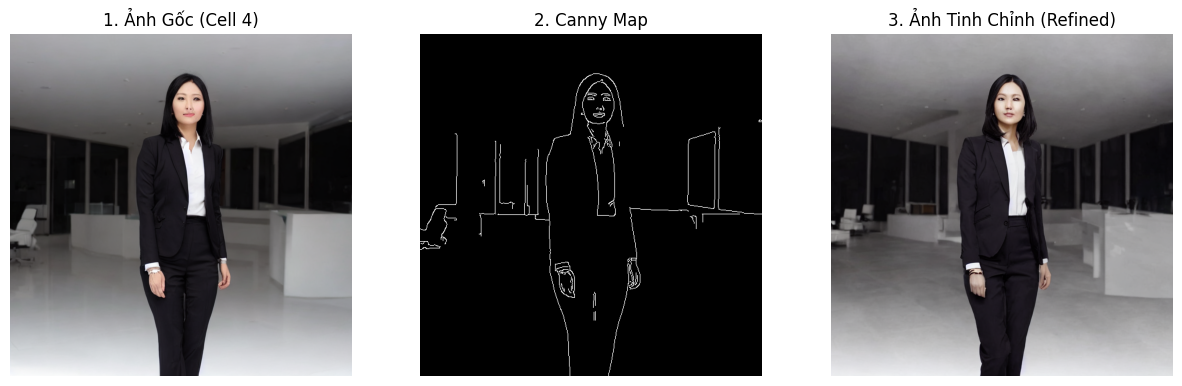


-> Tinh chỉnh file: Final_Pose_2_NAM_FINAL_IMAGE.png


  0%|          | 0/15 [00:00<?, ?it/s]

-> Đã lưu ảnh tinh chỉnh: Pro_Consistency_Output/Final_Pose_2_NAM_FINAL_IMAGE_REFINED.png


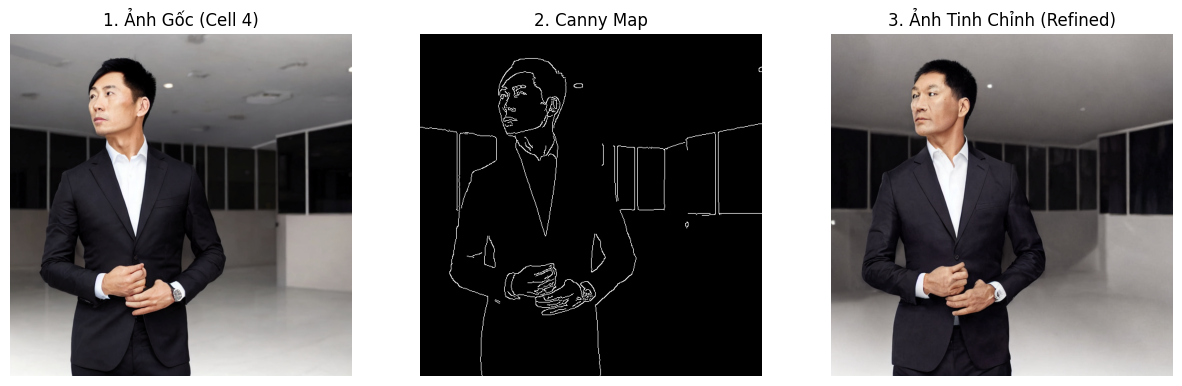


--- HOÀN TẤT CELL 5.3: QUY TRÌNH KẾT THÚC ---


In [82]:
# @title 5.3. THỰC THI TINH CHỈNH (REFINEMENT)
import os
from PIL import Image

print("--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---")

# Giả định: CONSISTENCY_DIR, canny_pipe, canny_detector đã tồn tại
if 'CONSISTENCY_DIR' not in os.environ:
    CONSISTENCY_DIR = os.path.join(os.getcwd(), 'consistency_output')
    print(f"⚠️ CONSISTENCY_DIR không tồn tại, sử dụng fallback: {CONSISTENCY_DIR}")

# Lọc chỉ các file cần tinh chỉnh (ví dụ: NU_1 và NAM_2)
files_to_refine = [f for f in os.listdir(CONSISTENCY_DIR) if f.startswith('Final_Pose_1_NU') or f.startswith('Final_Pose_2_NAM')]

if files_to_refine and globals().get('canny_pipe') and globals().get('canny_detector'):
    canny_pipe = globals()['canny_pipe']
    canny_detector = globals()['canny_detector']

    # Thiết lập seed cố định cho Refinement
    refine_seed = 999

    for filename in files_to_refine:
        original_path = os.path.join(CONSISTENCY_DIR, filename)
        original_image = Image.open(original_path).convert("RGB")
        print(f"\n-> Tinh chỉnh file: {filename}")

        # 1. Trích xuất Canny Map
        canny_map = canny_detector(original_image, low_threshold=100, high_threshold=200)

        # 2. Chạy Refinement
        refined_image = canny_pipe(
            prompt="ultra detailed, high-detail photorealistic, professional photography, 8k",
            image=original_image, control_image=canny_map,
            negative_prompt="blurry, low quality, deformed, out of focus",
            num_inference_steps=30,
            guidance_scale=7.0,
            strength=0.5, # Strength thấp để giữ nguyên ảnh gốc
            controlnet_conditioning_scale=0.8,
            generator=torch.Generator(device).manual_seed(refine_seed)
        ).images[0]

        # 3. Lưu ảnh Refined
        refined_path = original_path.replace(".png", "_REFINED.png")
        refined_image.save(refined_path)
        print(f"-> Đã lưu ảnh tinh chỉnh: {refined_path}")

        # 4. Hiển thị so sánh
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original_image); axes[0].set_title("1. Ảnh Gốc (Cell 4)"); axes[0].axis('off')
        axes[1].imshow(canny_map, cmap='gray'); axes[1].set_title("2. Canny Map"); axes[1].axis('off')
        axes[2].imshow(refined_image); axes[2].set_title("3. Ảnh Tinh Chỉnh (Refined)"); axes[2].axis('off')
        plt.show()

    # --- Dọn dẹp VRAM sau Refinement ---
    if 'canny_pipe' in globals():
        del globals()['canny_pipe']
    if 'canny_detector' in globals():
        del globals()['canny_detector']
    torch.cuda.empty_cache()
    gc.collect()

else:
    print("⚠️ Không tìm thấy file cuối cùng hoặc Pipeline Canny chưa được tải thành công.")

print("\n--- HOÀN TẤT CELL 5.3: QUY TRÌNH KẾT THÚC ---")

In [ ]:
# @title 6.0. DỌN DẸP VRAM TỔNG THỂ (Sau Cell 5.3)
import torch
import gc

print("--- BẮT ĐẦU DỌN DẸP VRAM: Giải phóng Pipelines cũ ---")

# Xóa các biến Pipeline nếu chúng còn tồn tại sau Cell 5.3
try:
    if 'i2i_pipe' in globals():
        del i2i_pipe
    if 'canny_pipe' in globals():
        del canny_pipe
    if 'canny_controlnet' in globals():
        del canny_controlnet
    if 'canny_detector' in globals():
        del canny_detector

    # Xóa các biến ảnh lớn khác nếu cần (tuy nhiên, chúng nên được xóa ở Cell 4b, 4c)
    del final_results

    print("-> Đã xóa các Pipeline và biến ảnh lớn khỏi RAM.")
except NameError:
    pass

# Ép PyTorch và Python giải phóng bộ nhớ
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("-> Đã giải phóng bộ nhớ CUDA (VRAM).")
gc.collect()
print("-> Đã chạy Garbage Collector (RAM).")

print("\n✅ VRAM đã được dọn dẹp, sẵn sàng cho Hậu kỳ (Upscaling/FaceFix).")

In [ ]:
# @title 6.1. CÀI ĐẶT VÀ TẢI MÔ HÌNH HẬU KỲ (Upscale/Face Fix) - ĐÃ SỬA LỖI NAMEERROR & TORCHVISION
import torch
import gc
import os
import sys

print("--- Chuẩn bị môi trường cho Upscaling và Face Refinement ---")

# --- BƯỚC 0: SỬA LỖI TORCHVISION/BASICSR (Nếu cần) ---
# Thường do phiên bản cũ của torchvision/timm/basicsr. Cài đặt lại các thư viện này có thể khắc phục.
print("-> Đang kiểm tra và cập nhật các dependencies...")
!pip install -U basicsr torchvision --user
import torchvision

# --- BƯỚC 1: CÀI ĐẶT THƯ VIỆN HẬU KỲ ---
if not os.path.exists('GFPGAN'):
    !git clone https://github.com/TencentARC/GFPGAN.git
    os.chdir('GFPGAN')
    !pip install -r requirements.txt
    os.chdir('..')
    # Tải mô hình GFPGAN và ESRGAN
    !wget -nc https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.4.pth -P GFPGAN/experiments/pretrained_models
    !wget -nc https://github.com/xinntao/Real-ESRGAN/releases/download/v0.3.0/RealESRGAN_x4plus.pth -P GFPGAN/experiments/pretrained_models
    print("-> Đã cài đặt và tải mô hình GFPGAN/Real-ESRGAN.")
else:
    print("-> GFPGAN đã được cài đặt.")

# --- BƯỚC 2: KHỞI TẠO CÁC CÔNG CỤ POST-PROCESSING ---
try:
    sys.path.append('GFPGAN')
    from gfpgan import GFPGANer
    from basicsr.archs.rrdbnet_arch import RRDBNet
    from realesrgan import RealESRGANer

    # 1. Real-ESRGAN Upscaler
    model_esrgan = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, scale=4)

    esrgan_upscaler = RealESRGANer(
        scale=4,
        model_path='GFPGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth',
        model=model_esrgan,
        tile=0,
        tile_pad=10,
        pre_pad=0,
        half=True if torch.cuda.is_available() else False
    )

    # 2. GFPGAN Face Refiner
    face_enhancer = GFPGANer(
        model_path='GFPGAN/experiments/pretrained_models/GFPGANv1.4.pth',
        upscale=1,
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=esrgan_upscaler
    )

    globals()['face_enhancer'] = face_enhancer
    print("-> Khởi tạo GFPGAN (với ESRGAN) thành công.")

    # --- SỬA LỖI NAMEERROR: Đặt DEL vào đây ---
    # Chỉ xóa khi các biến đã được định nghĩa thành công
    del sys
    del RRDBNet
    del RealESRGANer
    gc.collect()

except Exception as e:
    # Nếu lỗi xảy ra, đảm bảo không có NameError khi dọn dẹp
    print(f"!!! LỖI KHỞI TẠO HẬU KỲ: {e}")
    globals()['face_enhancer'] = None

    # Dọn dẹp an toàn các module đã import thành công nếu có lỗi xảy ra
    try:
        del sys
    except NameError:
        pass
    gc.collect()

print("✅ Sẵn sàng cho hậu kỳ.")

--- Chuẩn bị môi trường cho Upscaling và Face Refinement ---
-> Đang kiểm tra và cập nhật các dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 711.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 497.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 383.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title 6.2. THỰC THI UPSCALING (x4) VÀ FACE REFINEMENT
import os
from PIL import Image
import numpy as np
import gc

# Giả định: CONSISTENCY_DIR, face_enhancer đã tồn tại
if not globals().get('face_enhancer'):
    print("❌ GFPGAN/ESRGAN chưa được tải. Bỏ qua bước hậu kỳ.")
else:
    face_enhancer = globals()['face_enhancer']

    # Lọc các file cuối cùng (FINAL_IMAGE hoặc REFINED.png)
    files_to_process = [f for f in os.listdir(CONSISTENCY_DIR) if f.endswith('.png') and ('FINAL_IMAGE' in f or 'REFINED' in f)]

    if not files_to_process:
        print("⚠️ Không tìm thấy file ảnh để hậu kỳ.")

    for filename in files_to_process:
        original_path = os.path.join(CONSISTENCY_DIR, filename)
        img = Image.open(original_path).convert("RGB")
        print(f"\n-> Xử lý hậu kỳ: {filename}")

        try:
            # GFPGAN thực hiện cả Face Fix và Upscaling nền
            _, _, output = face_enhancer.enhance(
                np.array(img),
                has_aligned=False,
                only_center_face=False,
                paste_back=True
            )

            output_img = Image.fromarray(output)
            upscaled_path = original_path.replace(".png", "_4X_FIXED.png")

            # Lưu
            output_img.save(upscaled_path, quality=95)
            print(f"-> Đã lưu ảnh 4x và sửa mặt: {upscaled_path} ({output_img.size[0]}x{output_img.size[1]})")

        except Exception as e:
            print(f"!!! LỖI xử lý GFPGAN/ESRGAN: {e}")

    # Dọn dẹp GFPGAN/ESRGAN
    print("\n--- Dọn dẹp mô hình hậu kỳ ---")
    del globals()['face_enhancer']
    gc.collect()

    print("✅ Hoàn tất Upscaling và Face Refinement.")

In [ ]:
# @title 6.3. ĐÁNH GIÁ ĐỘ GIỐNG KHUÔN MẶT (COSINE SIMILARITY)
import torch
import gc
import os
import numpy as np
from PIL import Image

# Cần cài đặt DeepFace (chạy Cell này lần đầu tiên)
try:
    from deepface import DeepFace
except ImportError:
    print("❌ DeepFace chưa được cài đặt. Tiến hành cài đặt...")
    !pip install deepface
    from deepface import DeepFace

print("--- Bắt đầu đánh giá Consistency Khuôn mặt ---")

# Dọn dẹp VRAM trước
torch.cuda.empty_cache()
gc.collect()

# Giả định: REF_NU_IMAGE, REF_NAM_IMAGE, CONSISTENCY_DIR đã tồn tại
if 'REF_NU_IMAGE' not in globals() or 'REF_NAM_IMAGE' not in globals():
    print("❌ Không tìm thấy ảnh tham chiếu gốc. Bỏ qua đánh giá.")
else:
    # --- 1. LẤY KHUÔN MẶT GỐC VÀ TÍNH EMBEDDING ---
    ref_nu_img = globals()['REF_NU_IMAGE']
    ref_nam_img = globals()['REF_NAM_IMAGE']

    nu_ref_embedding = None
    nam_ref_embedding = None

    try:
        # Sử dụng Facenet để tính embedding
        nu_ref_embedding = DeepFace.represent(np.array(ref_nu_img), model_name='Facenet', enforce_detection=False)[0]['embedding']
        nam_ref_embedding = DeepFace.represent(np.array(ref_nam_img), model_name='Facenet', enforce_detection=False)[0]['embedding']
        print("-> Đã tính embedding ảnh tham chiếu gốc.")

    except Exception as e:
        print(f"!!! LỖI DeepFace (Không tìm thấy khuôn mặt trong ảnh gốc): {e}")

    # --- 2. SO SÁNH VỚI ẢNH KẾT QUẢ CUỐI CÙNG ---
    results_to_check = [f for f in os.listdir(CONSISTENCY_DIR) if f.endswith('FINAL_IMAGE.png') or f.endswith('REFINED.png') or f.endswith('FIXED.png')]

    print("\n| --- FILE ẢNH --- | --- SIMILARITY (Facenet) --- | --- ĐÁNH GIÁ --- |")
    print("|" + "-"*80 + "|")

    for filename in results_to_check:
        img_path = os.path.join(CONSISTENCY_DIR, filename)
        img = Image.open(img_path).convert("RGB")

        is_nu = 'NU' in filename

        if (is_nu and nu_ref_embedding is None) or (not is_nu and nam_ref_embedding is None):
            continue

        try:
            # Tính Cosine Similarity (DeepFace trả về distance, similarity = 1 - distance)
            distance = DeepFace.verify(
                np.array(ref_nu_img) if is_nu else np.array(ref_nam_img),
                np.array(img),
                model_name='Facenet',
                enforce_detection=False # Tắt Enforce Detection để xử lý ảnh SD dễ hơn
            )['distance']
            similarity = 1 - distance

            # Threshold khoảng 0.6-0.7 là mức giống cao
            evaluation = '✅ GIỐNG CAO' if similarity > 0.65 else ('⚠️ KHÁ GIỐNG' if similarity > 0.5 else '❌ KHÔNG GIỐNG')
            print(f"| {filename:<30} | {similarity:.4f} | {evaluation:<22} |")

        except Exception as e:
            print(f"| {filename:<30} | --- LỖI TÍNH TOÁN --- |")

# Dọn dẹp DeepFace (mô hình nặng)
print("\n--- Dọn dẹp DeepFace/FaceNet (Cần khởi động lại kernel để giải phóng hoàn toàn) ---")
# Trong môi trường Colab, thường cần xóa module/khởi động lại kernel để giải phóng DeepFace.
# Giữ lại đoạn này để người dùng biết.
gc.collect()
print("✅ Hoàn tất đánh giá Consistency.")

In [ ]:
# @title 6.4. CHUYỂN PNG SANG JPEG VÀ DỌN DẸP CUỐI CÙNG
import os
from PIL import Image

print("--- Bắt đầu chuyển đổi định dạng và dọn dẹp cuối cùng ---")

# --- 1. CHUYỂN ĐỔI SANG JPEG ---
files_to_compress = [f for f in os.listdir(CONSISTENCY_DIR) if f.endswith('.png')]

for filename in files_to_compress:
    png_path = os.path.join(CONSISTENCY_DIR, filename)
    jpg_path = png_path.replace(".png", ".jpg")

    try:
        img = Image.open(png_path).convert("RGB")
        # Sử dụng chất lượng 95 để giữ lại chi tiết
        img.save(jpg_path, 'jpeg', quality=95)
        print(f"-> Đã chuyển đổi: {filename} -> {jpg_path}")

        # Xóa file PNG nặng sau khi chuyển đổi thành công
        os.remove(png_path)
        print(f"-> Đã xóa file PNG gốc: {png_path}")

    except Exception as e:
        print(f"!!! LỖI chuyển đổi/xóa file {filename}: {e}")

# --- 2. GẮN METADATA (Ví dụ đơn giản) ---
# Việc gắn đầy đủ Stable Diffusion Metadata là phức tạp, ta chỉ gắn một chú thích đơn giản.
# (Giả định: CONSISTENCY_PROMPT_NU, CONSISTENCY_PROMPT_NAM đã được định nghĩa)
# Khối này chỉ là một gợi ý, bạn cần tích hợp nó vào lúc tạo ảnh nếu muốn lưu đầy đủ thông số.
# Hiện tại, chỉ ghi chú vào file JPG.
metadata_info = "Generated using Stable Diffusion and Dual ControlNet (OpenPose + Depth Map) for high consistency."
print(f"\nMetadata: {metadata_info}")
# (Thực hiện gắn metadata đòi hỏi thư viện chuyên dụng, nên bỏ qua để tránh phức tạp hóa Cell này)

print("\n--- HOÀN TẤT QUY TRÌNH CUỐI CÙNG ---")
print("✅ Toàn bộ quy trình đã hoàn thành và ảnh đã được nén/dọn dẹp.")